# Deep Learning for Computer Vision:  HW 3


## Computer Science: COMS W 4995 004


### Due: October 20, 2020

#### Problem

a) You are given two dimensional input from three separate classes. Your task is to implement a multi-layer perceptron (MLP) 3-class classifier with multiple hidden layers and a regularization on the weights. For the activiation function of the hidden units use ReLU or leaky ReLU. For the predictions use softmax on a linear output layer as we did in class. Your loss layer should compute $-\log P(y = i \,|{\bf x})$ where $i$ is the correct label according to the training data.

Implement each layer type (hidden, output, and loss) as separate python classes, each with methods for initialization, forward propagation, and backpropagation.

Implement a MLP as its own class, with separate methods for initialization, adding a layer, forward propagation, backpropagation, training and prediction. 

Let the layer dimensions be parameters passed when the network is created.

Let the number of training epochs, the mini-batch size, and the regularization parameter be parameters that are passed when training the network.

Build and run your network using your own constructs. The code for doing this might look like what is shown in the next box below.

b) Show the decision regions of the trained classifier by densely generating points in the plane and color coding these points with the three different labels. 

c) Repeat varying the number of hidden units (3, 8, 16), the number of hidden layers (1 and 3), and the regularization value (0 and some other value of your choosing).

d) Re-use this same network on any data of your own choosing. You can increase the dimensionality of the features space as you like. You can also change the number of classes to just two or more than three to align with your data. Separate your data into three piles: training, testing, and validation. Use your testing data to decide when to stop training if appropriate. Use your validation set to compute the accuracy of you classfier. 

In [1]:
# NN = MLP()
# NN.add_layer('Hidden', dim_in=2, dim_out=16)
# NN.add_layer('Hidden', dim_in=16, dim_out=16)
# NN.add_layer('Hidden', dim_in=16, dim_out=16)
# NN.add_layer('Output', dim_in=16, dim_out=3)
# NN.add_layer('Loss', dim_in=3, dim_out=3)

# loss = NN.train(X, y, epochs=100, bsize=8, alpha=0.0)
# plot_loss(loss)
# plot_decision_regions(NN)

 

#### NOTE:  Do not to use keras, tensorflow, pytorch, sklearn, etc. to do this.  You must build the machine learning components from scratch.  

#### YOUR CODE MUST BE YOUR OWN.
_______________________________________________________________



Copying grading checklist below

Hi all, here is a check list(rough rubric) for HW3.
This is pretty much the same as what questions asked. You might want to check all those below
before submit your HW.

a)  60 points
Will be focusing on whether you satisfied all required conditions when building and training your network. Points will be (roughly) evenly allocated to the following conditions.
1. If you implemented each (hidden, output, loss) layer type as separate classes and had all mentioned functions for each class.
2. If you Implement a MLP class with all mentioned functions.
3. If you used the required activation function.
4. If you used softmax.
5. If loss is correctly computed.
6. Layers’ dimensions are properly passed as required.
7. Training parameters are properly passed as required.
8. If you used regularization in a correct way
9. Run the network using the same or similar code given in the notebook.

b) 5 points
1. If you densely generated points for the whole plane in a proper way.
2. If you colored the points in a correct way

c) 15 points
If you tried all required parameters and plotted the decision region for each.

d) 20 points
1. If you separated your data
2. If you implemented early stopping correctly
3. If you computed accuracy

It could be changed a bit during grading, but not much. There will be deduction in points if the results are not as expected.
In HW2, there were many students implemented models correct but not trained it enough.  Try to use matrices in minibatch calculations(not calculating individual samples using for loop). Then it will take not too long to train more epochs.

Let's start by importing some libraries.

In [2]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Let's make up our 2D data for our three classes.

In [3]:
data = pd.DataFrame(np.zeros((5000, 3)), columns=['x1', 'x2', 'y'])

# Let's make up some noisy XOR data to use to build our binary classifier
for i in range(len(data.index)):
    x1 = random.randint(0,1)
    x2 = random.randint(0,1)
    if x1 == 1 and x2 == 0:
        y = 0
    elif x1 == 0 and x2 == 1:
        y = 0
    elif x1 == 0 and x2 == 0:
        y = 1
    else:
        y = 2
    x1 = 1.0 * x1 + 0.20 * np.random.normal()
    x2 = 1.0 * x2 + 0.20 * np.random.normal()
    data.iloc[i,0] = x1
    data.iloc[i,1] = x2
    data.iloc[i,2] = y
    
for i in range(int(0.25 *len(data.index))):
    k = np.random.randint(len(data.index)-1)  
    data.iloc[k,0] = 1.5 + 0.20 * np.random.normal()
    data.iloc[k,1] = 1.5 + 0.20 * np.random.normal()
    data.iloc[k,2] = 1

for i in range(int(0.25 *len(data.index))):
    k = np.random.randint(len(data.index)-1)  
    data.iloc[k,0] = 0.5 + 0.20 * np.random.normal()
    data.iloc[k,1] = -0.75 + 0.20 * np.random.normal()
    data.iloc[k,2] = 2
    
# Now let's normalize this data.
data.iloc[:,0] = (data.iloc[:,0] - data['x1'].mean()) / data['x1'].std()
data.iloc[:,1] = (data.iloc[:,1] - data['x2'].mean()) / data['x2'].std()
        
data.head()

,x1,x2,y
0,0.333203,-0.451681,0.0
1,0.854303,-0.871882,0.0
2,-1.050987,-0.906546,1.0
3,-1.244254,0.735518,0.0
4,1.928320,1.454068,1.0


Let's message this data into a numpy format.

In [4]:
# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
X = np.matrix(X.values)
y = np.matrix(y.values)

Let's make a sloppy plotting function for our binary data.

In [5]:
# Sloppy function for plotting our data
def plot_data(X, y_predict):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    indices_0 = [k for k in range(0, X.shape[0]) if y_predict[k] == 0]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k] == 1]
    indices_2 = [k for k in range(0, X.shape[0]) if y_predict[k] == 2]

    ax.plot(X[indices_0, 0], X[indices_0,1], marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1,1], marker='o', linestyle='', ms=5, label='1')
    ax.plot(X[indices_2, 0], X[indices_2,1], marker='o', linestyle='', ms=5, label='2')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Tricky 3 Class Classification')
    plt.show()

Now let's plot it.

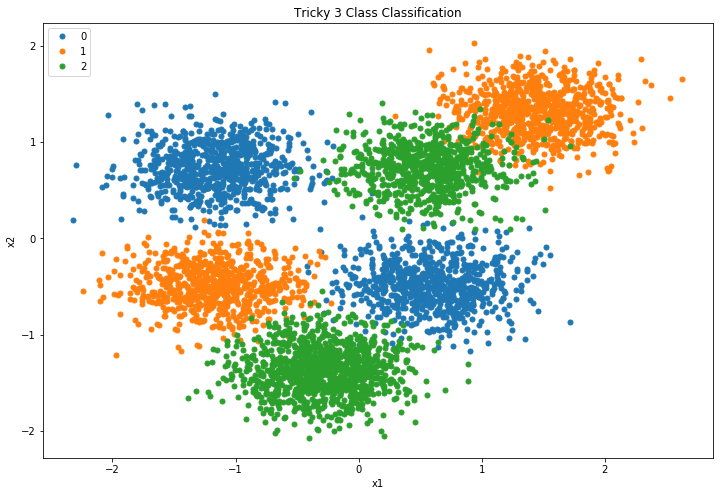

In [6]:
plot_data(X, y)

Now build your network. Good luck! 😉 

This is for plotting dense sample later. Basically will change `y` into something like `[0, 1, 2, 1, 2, 0]`, i.e. from shape `(5000, 1)` to `(5000,)`.

In [7]:
y_int_labels = np.array(y.flatten(), dtype='int32')[0]
assert y_int_labels.shape == (5000,)

Change `X` and `y` into `ndarray` and do sanity check

In [8]:
X = np.array(X)
y = np.array(y)

assert X.shape == (5000, 2)
print(X[0:3])

assert y.shape == (5000, 1)
print(y[0:3])

[[ 0.33320275 -0.45168072]
 [ 0.85430333 -0.87188185]
 [-1.05098699 -0.90654616]]
[[0.]
 [0.]
 [1.]]


Apply `one hot encoding` to `y`, check if the encoding is correct by comparing the `one-hot-encoded y`to the `y` printed above

In [9]:
data = np.array(y.flatten(), dtype='int32')
shape = (data.size, int(data.max() + 1))

y = np.zeros(shape)
rows = np.arange(data.size)

y[rows, data] = 1.0
print(y[0:3])

[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


### a) Implement MLP

#### a.1 Implement each layer type (hidden, output, and loss) as separate python classes, each with methods for initialization, forward propagation, and backpropagation.

First, create a base class `Layer`

In [10]:
# Use Abstract Base Class from Python standard lib
from abc import ABC, abstractmethod
 
class Layer(ABC):
    
    # Some initializations for Layer:
    # 1. Assign dimensions (dim_in, dim_out)
    # 2. Assign weight_init strategy
    def __init__(self, name, dim_in=None, dim_out=None, weight_init='standard', debug=False):
        self.name = name
        
        self.dim_in = dim_in
        self.dim_out = dim_out
     
        if isinstance(self, Input) or isinstance(self, Hidden) or isinstance(self, Output):
            self.weight_init = weight_init
            self.init_weights()
            
        self.debug = debug
        
    # Initialize weights using weight_init strategy
    def init_weights(self):
        init_method = self.weight_init.lower()
        
        # Here I only implement one strategy, using Standard Normal distribution
        if init_method == 'standard':
            self.W = np.random.normal(0, 1, self.dim_in*self.dim_out).reshape(self.dim_in, self.dim_out)
            
        else:
            raise Exception('Non-supported initialization method')
            
        # For bias, simply set to zeros
        self.b = np.zeros(self.dim_out, dtype='float32')
    
    # Abstract forward method for Layer, 
    # taking both inputs X and y to calculate activation/loss
    @abstractmethod
    def forward_propagate(self, X, y):
        # To be implemented in the child class
        pass
    
    # Abstract back propagate method for Layer, 
    # taking grads from previous layer
    @abstractmethod
    def back_propagate(self, grads):
        # To be implemented in the child class
        pass

Second, create a `Linear` `Layer`, i.e. simply a feedforward `Layer`

In [11]:
class Linear(Layer):
    
    # Parent initialization
    def __init__(self, name, dim_in, dim_out, debug=False):
        super().__init__(name, dim_in, dim_out, debug)
    
    # W is param weight and b is intercept/bias
    def forward_propagate(self, X, y=None):
        # Simply save the input 
        self.X = X
        
        # and return the WX + b value
        return np.dot(X, self.W) + self.b
    
    # Compute grads for both W and b
    def back_propagate(self, grads):
        # For W, we do matrix multiplication between our input X
        # and the gradients from previous layer and then take 
        # the average over the resulting columns, i.e. axis=0
        # The tricky thing here is that we have to match the shape to be able
        # to do the multiplication. For X, we add newaxis as the third dimension
        # meanwhile for the grads, we add it as the second dimension
        self.grad_W = (np.matmul(self.X[:, :, np.newaxis], grads[:, np.newaxis,:])).mean(axis=0)
        
        # For the intercept, we simply take the gradients average
        # We can think of this as having input X equals to vector of 1s,
        # or in numpy something like np.full(shape, 1.0),
        # which if we multiply with our grads will result in the grads itself
        self.grad_b = grads.mean(axis=0)
        
        # The gradients to be passed to the next (or prev I should say) layer
        # is computed by taking dot product of the current gradients 
        # and this layer weights
        return np.dot(grads, self.W.transpose())

Third, create class for `Input`, `Hidden` layer and `Output` `Layer`

All the three classes are basically the same since I already create a `Linear` `Layer` as their parent. But, for the sake of the assignment requirement, which is to have separate classes for each `Layer`, then I implement them as below

In [12]:
class Input(Linear):
    
    def __init__(self, name, dim_in, dim_out, debug=False):
        super().__init__(name, dim_in, dim_out, debug)
        
class Hidden(Linear):

    def __init__(self, name, dim_in, dim_out, debug=False):
        super().__init__(name, dim_in, dim_out, debug)

class Output(Linear):
    
    def __init__(self, name, dim_in, dim_out, debug=False):
        super().__init__(name, dim_in, dim_out, debug)

Now, we're done with all the feedforward `Layer`

Next, let's implement the `Activation` and `Loss` class, which are also the child of the base class `Layer`.

In [13]:
# For Activation, I cover two types: ReLU and Softmax
class Activation(Layer):
    
    def __init__(self, name, debug=False):
        super().__init__(name, debug)
        
    def apply_relu(self): 
        # For ReLU, need to keep X original values
        # for backpropagation later
        self.X_linear = np.copy(self.X)
        
        # Clip all negative values to zero
        return np.clip(self.X, 0, None)
    
    def apply_softmax(self):
        # Simply use the formula (e^x / sum(e^x))
        # Take the average over the row, i.e. axis=1
        # The tricky thing here is we need to expand the dimension
        # so it's easier later to backpropagate
        # Save these values as well for later backpropagation
        self.y_probs = np.exp(self.X) / np.exp(self.X).sum(axis=1)[:, np.newaxis]
    
        return self.y_probs
    
    def compute_relu_derivative(self, grads):
        # Simply replace all positive values to the received grads
        return np.where(self.X_linear > 0, grads, 0)
    
    def compute_softmax_derivative(self, grads):
        # Again, expand the dimension for the sake of the backpropagation
        return self.y_probs * (grads - (grads * self.y_probs).sum(axis=1)[:, np.newaxis])

    # Wrapper for activations, i.e. choosing actions based on param
    def activate(self):
        if 'relu' in self.name: 
            activation_func = self.apply_relu
            
        elif 'softmax' in self.name:
            activation_func = self.apply_softmax
        
        else:
            raise Exception('Non-supported activation function')
            
        return activation_func()
    
    # Forward action for Activation layer is simply
    # calling the activation function, thus y is unneeded
    def forward_propagate(self, X, y=None):
        self.X = X
        
        return self.activate()
    
    # Backproagation action for Activation layer
    # is computing the derivative/gradients
    def back_propagate(self, grads):
        if 'relu' in self.name:
            derivative_func = self.compute_relu_derivative
            
        elif 'softmax' in self.name:
            derivative_func = self.compute_softmax_derivative
        
        else:
            raise Exception('Non-supported activation function')
            
        return derivative_func(grads)

# For Loss, I cover only Cross Entropy loss
class Loss(Layer):
    
    def __init__(self, name, debug=False):
        super().__init__(name, debug)
        
    # X has shape of (num_examples, num_classes)
    # y has shape of (num_examples,)
    # IMPORTANT: y needs to be ONE-HOT ENCODED 
    # IMPORTANT: APPLY SOFTMAX to X beforehand
    def apply_cross_entropy(self):
        return (np.where(self.y==1.0, -np.log(self.X), 0.0)).sum(axis=1)  
    
    def compute_L2_loss(self):
        reg_loss = 0.0
        n_examples = self.X.shape[0]
        n_layers = len(self.layer_W)
        
        # Sum L2 loss over all layer weights
        for W in self.layer_W:
            reg_loss = reg_loss + np.sum(np.square(W))
        
        # Divide total L2 loss by n_layers*n_examples, amplify by alpha
        return (self.alpha/(n_layers*n_examples)) * reg_loss
    
    # Wrapper for losses, i.e. choosing actions based on param
    def compute_loss(self):
        if self.debug:
            print('y_out shape: {}'.format(y_out.shape))
            print('y shape: {}'.format(y.shape))
            
        if 'cross_entropy' in self.name:
            loss_func = self.apply_cross_entropy
            
        else:
            raise Exception('Non-supported loss function')
        
        loss = loss_func()
        
        # Add regularization loss if specified
        if self.reg_type != None:
            loss = loss + self.compute_regularization_loss()
        
        return loss
    
    # Wrapper for regularization losses, i.e. choosing actions based on param
    def compute_regularization_loss(self):
        if self.reg_type == 'L2':
            reg_loss = self.compute_L2_loss()
            
        else:
            raise Exception('Non-supported regularization type')
            
        return reg_loss
    
    # Forward action for Loss layer is computing the loss,
    # thus the true label y is needed
    def forward_propagate(self, X, y, regularizer):
        self.X = X
        self.y = y
        
        self.reg_type = None
        
        if regularizer is not None:
            self.reg_type = regularizer['reg_type']
            self.alpha = regularizer['alpha']
            self.layer_W = regularizer['layer_W']
        
        return self.compute_loss()
    
    # Backpropagation action for Loss layer is computing the 
    # derivative/gradients given the classification mismatch
    # In this case, for Cross Entropy, we set the derivation
    # value to (-1/X), which is the derivative of natural log
    # We do that for all the indexes where the true label lies
    # Remember we do one hot encoding, so there are only 0s and 1
    def back_propagate(self, grads=None):    
        return np.where(self.y==1.0, -1/self.X, 0.0)

# A function to check if the above implementation is correct
def check_activation_and_loss_imp():
    y_out = np.array([1.0, -2.0, 3.0, -5.0])
    
    reluAct = Activation('relu_0')
    assert (reluAct.forward_propagate(y_out) == np.array([1., 0., 3., 0])).all()
    
    y_out = np.array([[1.0, 2.0, 3.0], [2.0, 2.0, 2.0]])
    
    softmaxAct = Activation('softmax_0', False)
    y_out_softmax = softmaxAct.forward_propagate(y_out)
    
    print(np.sum(y_out_softmax, axis=1))
    
    crossEntropyLoss = Loss('cross_entropy_0')
    print(crossEntropyLoss.forward_propagate(y_out_softmax, np.array([[1.0, 0.0, 0.0], [0.0, 0.0, 1.0]]), None))

Sanity checks to see if `Activation` and `Loss` implementation is correct:

In [14]:
check_activation_and_loss_imp()

[1. 1.]
[2.40760596 1.09861229]


#### a.2 Implement a MLP as its own class, with separate methods for initialization, adding a layer, forward propagation, backpropagation, training and prediction.

Finally, an `MLP` class

In [15]:
class MLP():
    
    # Initialize Layers placeholder
    def __init__(self, debug=True):
        self.layers = []
        
        self.debug = debug
        
    # Let the layer type (there is 5), dimensions (in and out) and 
    # weight initialization strategy be parameters passed when adding a layer
    def add_layer(self, layer_type, dim_in=None, dim_out=None, weight_init='standard'):
        layer_type = layer_type.lower()
        
        num_of_layers = sum(layer_type in layer.name for layer in self.layers)
        
        # The layer names would be something like: input_0, relu_0, 
        # hidden_0, relu_1, output_0, softmax_0, loss_0
        name = layer_type + '_' + str(num_of_layers)
        
        if layer_type == 'input':
            self.layers.append(Input(name, dim_in, dim_out, weight_init))
            
        elif layer_type == 'hidden':
            self.layers.append(Hidden(name, dim_in, dim_out, weight_init))
        
        elif layer_type == 'output':
            self.layers.append(Output(name, dim_in, dim_out, weight_init))
            
        elif 'activation' in layer_type:
            self.layers.append(Activation(name))
            
        elif 'loss' in layer_type:
            self.layers.append(Loss(name))
        
        else:
            raise Exception('Non-supported layer type')
    
    # Basically calling forward_propagate from all layers
    # Set include_loss to True for training because 
    # we need it to compute the gradients
    # Set include_loss to False for prediction because
    # we only need the Softmax probabilities output
    def forward_propagate(self, X, y, include_loss, regularizer):
        if self.debug:
            print('Forward propagating...')
            print('Input shape: {}'.format(X.shape))
        
        for layer in self.layers:
            if self.debug:
                print('Layer name: {}'.format(layer.name))
                    
            if not isinstance(layer, Loss):

                X = layer.forward_propagate(X)

                if self.debug:
                    print('Output shape: {}'.format(X.shape))
                    
            else:
                if include_loss:
                    loss = layer.forward_propagate(X, y, regularizer)

                    if self.debug:
                        print('Loss shape: {}'.format(loss.shape))
                        
        if include_loss:
            return loss 
        else:
            return X
    
    # Basically calling back_propagate from all layers
    # See that we chain the grads here by passing computed grads from
    # the current layer to the next (or should I say previous) layer
    def back_propagate(self):
        if self.debug:
            print('Back propagating...')
            
        grads = None
        
        for layer in reversed(self.layers):
            if self.debug:
                print('Layer name: {}'.format(layer.name))

            grads = layer.back_propagate(grads)

            if self.debug:
                print('Losses shape: {}'.format(losses.shape))
    
    # Update the weights using the computed grads/derivaties 
    # and the input learning_rate
    # Note that we only update for Linear layers here
    def update_weights(self, learning_rate):
        for layer in self.layers:
            if isinstance(layer, Linear):
                layer.W = layer.W - learning_rate * layer.grad_W
                layer.b = layer.b - learning_rate * layer.grad_b
    
    # Main training routine
    # Let the number of training epochs, the mini-batch size, and the 
    # regularization parameter be parameters that are passed when 
    # training the network.
    def train(self, X, y, learning_rate, epochs, bsize, regularizer):
        # IMPORTANT: I enforce that the last layer should be a Loss layer
        if not isinstance(self.layers[len(self.layers) - 1], Loss):
            raise Exception('Last layer is not a Loss layer')
        
        # Loss placeholder with size equals to epochs
        losses = []
        
        # Loop over epochs
        for i in range(0, epochs):
            # Reset loss and start index for every epoch
            # idx_start is used to implement mini batch scenario
            loss = 0.0
            idx_start = 0
            
            # Iterate for all minibatches
            while idx_start < X.shape[0]:
                # A minibatch is defined by [idx_start:idx_end]
                idx_end = idx_start + bsize
                
                # For the last batch, if idx_end is greater
                # than the number of samples, then clip it
                if idx_end > X.shape[0]:
                    idx_end = X.shape[0]
                
                # Get minibatch
                X_minbatch, y_minbatch = X[idx_start:idx_end], y[idx_start:idx_end]
                
                # If regularizer is used, we need to pass every layer weights
                # to the Loss layer to compute regularization loss
                if regularizer is not None:
                    regularizer['layer_W'] = []
                    
                    for layer in self.layers:
                        if isinstance(layer, Linear):
                            regularizer['layer_W'].append(layer.W)
 
                # Sum the loss cumulatively for every batch
                # Here, we call forward_propagate to do that   
                loss = loss + self.forward_propagate(X_minbatch, y_minbatch, include_loss=True, regularizer=regularizer).sum()
            
                # Call back_propagate to compute and set the gradients,
                # both for W and b for each layer
                self.back_propagate()
                
                # Update weights, only for Linear layer
                self.update_weights(learning_rate)
                        
                # Adjust idx_start for next minibacth
                idx_start = idx_start + bsize
            
            # Save average loss for current epoch
            avg_loss = loss / X.shape[0]
            losses.append(avg_loss)
            
            # Compute training accuracy
            train_acc = self.compute_accuracy(X, y)
            
            # Print info every 10 iterations
            if (i+1) % 10 == 0:
                print('Epoch: {}, Average Training Loss: {}, Train Accuracy: {}'.format(i+1, avg_loss, train_acc))
        
        return np.array(losses)
    
    # Predict return arrays of label, i.e. [0, 2, 1, 0, 2]
    # given input X (2D)
    def predict(self, X):
        # Get Softmax probabilities through forward propagation
        y_out_probs = self.forward_propagate(X, None, include_loss=False, regularizer=None)
        
        # For each sample, i.e. each row, take the index
        # which has maximum probability, denoting the label
        return np.argmax(y_out_probs, axis=1)
    
    # Additional function to compute accuracy
    def compute_accuracy(self, X, y):
        y_true_labels = np.argmax(y, axis=1)
        y_preds = self.predict(X)
        
        verdict = [1 if y1 == y2 else 0 for y1, y2 in zip(y_true_labels, y_preds)]

        return np.sum(verdict) / len(verdict)

#### a.3 Build and run your network using your own constructs. The code for doing this might look like what is shown in the next box below.

Build our `MLP`, train it and get the losses. `LEARNING_RATE = 0.01` (that is the same as `Keras` default) and `BSIZE=256`, I find that `BSIZE=8` is unnecessary since it is longer to train and using `BSIZE=256` doesn't greatly reduce performance. Thus, for every epoch, there will be ~`20` minibatches. `EPOCHS` is set to `100`.

In [16]:
NN = MLP(debug=False)

# Input Layer of shape (2, 3) with 2 being the size of feature
NN.add_layer('Input', dim_in=2, dim_out=3)
# Use ReLU activation for Input Layer
NN.add_layer('Activation_Relu')

# Hidden Layer of shape (3, 3) with 3 being the number of hidden units
NN.add_layer('Hidden', dim_in=3, dim_out=3)
# Also use ReLU activation for Hidden Layer
NN.add_layer('Activation_Relu')

# Output Layer of shape (3, 3) with 3 in dim_out being the number of classes
NN.add_layer('Output', dim_in=3, dim_out=3)
# Use Softmax activation to get smooth class probabilities
NN.add_layer('Activation_Softmax')

# Cross Entropy Loss Layer to compute the loss based on Softmax activations
NN.add_layer('Loss_Cross_Entropy')

# Finally, train the NN and fetch the losses
print('No regularizer is used')
print('---------------------------------')

print('Training for {} hidden layer(s) and {} hidden units'.format(3, 3))
print('---------------------------------')

# LEARNING_RATE = 0.01 (also Keras default) and BSIZE=256, I find that BSIZE=8 is too long to train
# And using BSIZE=256 doesn't greatly reduce performance
# Thus, for every epoch, there will be ~20 minibatches
# EPOCHS is set to 100, pretty standard
losses = NN.train(X, y, learning_rate=0.01, epochs=100, bsize=256, regularizer=None)

No regularizer is used
---------------------------------
Training for 3 hidden layer(s) and 3 hidden units
---------------------------------
Epoch: 10, Average Training Loss: 1.0034601567936376, Train Accuracy: 0.6048
Epoch: 20, Average Training Loss: 0.863579943136871, Train Accuracy: 0.7004
Epoch: 30, Average Training Loss: 0.7367659493656968, Train Accuracy: 0.7506
Epoch: 40, Average Training Loss: 0.6534518466896605, Train Accuracy: 0.7644
Epoch: 50, Average Training Loss: 0.6011923931438163, Train Accuracy: 0.7688
Epoch: 60, Average Training Loss: 0.56543966164454, Train Accuracy: 0.7724
Epoch: 70, Average Training Loss: 0.539763721712863, Train Accuracy: 0.7752
Epoch: 80, Average Training Loss: 0.5205845341190604, Train Accuracy: 0.7778
Epoch: 90, Average Training Loss: 0.5055441503891438, Train Accuracy: 0.7812
Epoch: 100, Average Training Loss: 0.4934575027117142, Train Accuracy: 0.783


Plot the losses for 100 epochs

In [17]:
def plot_losses(errors, title):
    n_iters = len(errors)
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    
    ax.plot(np.arange(1, n_iters + 1, 1), errors)

    ax.legend()
    ax.legend(loc=2)
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Average Losses')
    
    ax.set_title(title)
    
    plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


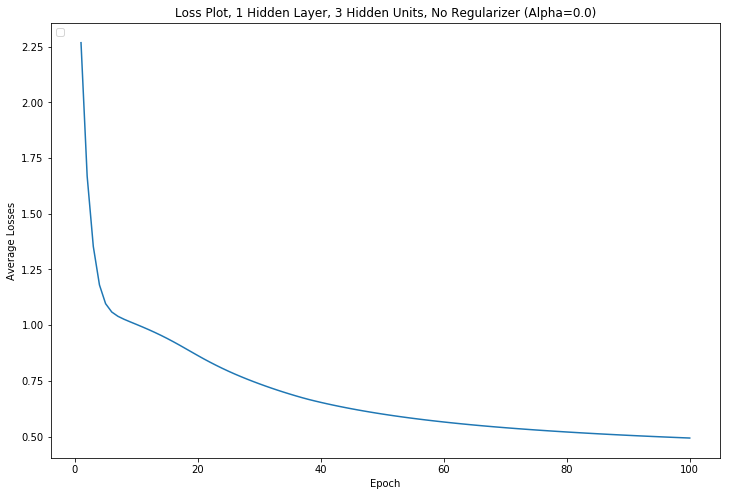

In [18]:
plot_losses(losses, 'Loss Plot, {} Hidden Layer, {} Hidden Units, No Regularizer (Alpha={})'.format(1, 3, 0.0))

### b) Show the decision regions of the trained classifier by densely generating points in the plane and color coding these points with the three different labels.

The code below is the same code that I used for HW2

In [19]:
# Generate 2D dense data for decision boundary
# The dense samples are square in shape, so x1_low == x2_low and x1_high == x2_high
def generate_dense_data_2d(network, low, high, step):
    # How many dots are within one line, either vertically and horizontally
    reps = int((high - low) / step) + 1
    
    # Generate different x1s using np.arange
    x1 = np.arange(low, high + step, step)
    # Repeat, so we get something like: [-0.5, -0.5, -0.5, -0.4, -0.4, -0.4, ...]
    x1 = np.repeat(x1, reps)
    
    # Generate different x2s using np.arange, but the value is actually the same as x1s
    x2 = np.arange(low, high + step, step)
    # Make a tile, so we get something like: [-0.5, -0.4, -0.3, -0.5, -0.4, -0.3, ...]
    x2 = np.tile(x2, reps)
    
    # Set a placeholder of size reps squared
    n_data = reps ** 2
    dense_data = pd.DataFrame(np.zeros((n_data, 3)), columns=['x1', 'x2', 'y'])

    # Assign x1s and x2s to the placeholder, each as separate series
    dense_data.iloc[:, 0] = x1
    dense_data.iloc[:, 1] = x2
   
    # Create np.matrix of X feature to be feed to the network
    # then convert it to np.array
    X = np.array(np.matrix(dense_data.iloc[:, 0:2].values))

    # Get probability distribution of label y given X
    y = network.predict(X)
    
    # Assign ys to the placeholder
    dense_data.iloc[:, 2] = y
    
    return dense_data

# Convert from DataFrame to Numpy and do sanity check
def convert_to_numpy(data):
    # set X (training data) and y (target variable)
    cols = data.shape[1]
    X = data.iloc[:, 0:cols-1]
    y = data.iloc[:, cols-1:cols]

    # The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
    X = np.matrix(X.values)
    y = np.matrix(y.values)
    
    return X, y

# Convert from DataFrame to Numpy and do sanity check
def convert_and_check_data(data, n_data, dim):
    X, y = convert_to_numpy(data)

    y_modified = y.flatten()
    y_modified = np.array(y_modified)[0]

    assert X.shape == (n_data, dim)
    assert y_modified.shape == (n_data,)
    
    return X, y_modified

# Modify plot data to enable plotting overlay
def plot_data_overlay(X, y, X_dense, y_dense, title, colorset):
    c0, c1, c2, c0_dense, c1_dense, c2_dense = colorset[0], colorset[1], colorset[2], colorset[3], colorset[4], colorset[5]
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    
    indices_0_dense = [k for k in range(0, y_dense.shape[0]) if y_dense[k] == 0]
    indices_1_dense = [k for k in range(0, y_dense.shape[0]) if y_dense[k] == 1]
    indices_2_dense = [k for k in range(0, y_dense.shape[0]) if y_dense[k] == 2]
    
    ax.plot(X_dense[indices_0_dense, 0], X_dense[indices_0_dense, 1], color=c0_dense, marker='o', linestyle='', ms=5)
    ax.plot(X_dense[indices_1_dense, 0], X_dense[indices_1_dense, 1], color=c1_dense, marker='o', linestyle='', ms=5)
    ax.plot(X_dense[indices_2_dense, 0], X_dense[indices_2_dense, 1], color=c2_dense, marker='o', linestyle='', ms=5)
    
    indices_0 = [k for k in range(0, y.shape[0]) if y[k] == 0]
    indices_1 = [k for k in range(0, y.shape[0]) if y[k] == 1]
    indices_2 = [k for k in range(0, y.shape[0]) if y[k] == 2]
    
    ax.plot(X[indices_0, 0], X[indices_0, 1], color=c0, marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1, 1], color=c1, marker='o', linestyle='', ms=5, label='1')
    ax.plot(X[indices_2, 0], X[indices_2, 1], color=c2, marker='o', linestyle='', ms=5, label='2')

    ax.legend()
    ax.legend(loc=2)
    
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    
    ax.set_title(title)
    plt.show()

In [20]:
dense_data = generate_dense_data_2d(NN, -3, 3, 1e-2)

dense_X, dense_y = convert_and_check_data(dense_data, 361201, 2)

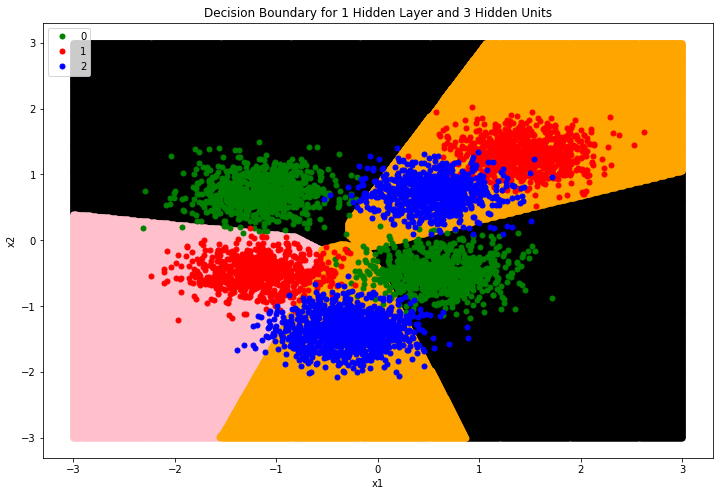

In [21]:
colorset = ['green', 'red', 'blue', 'black', 'pink', 'orange']

plot_data_overlay(X, y_int_labels, dense_X, dense_y, 'Decision Boundary for 1 Hidden Layer and 3 Hidden Units', colorset)

As a note:

1. BLACK regions correspond to GREEN dots, i.e. Class 0
2. PINK regions correspond to RED dots, i.e. Class 1
3. YELLOW regions correspond to BLUE dots, i.e. Class 2

### c) Repeat varying the number of hidden units (3, 8, 16), the number of hidden layers (1 and 3), and the regularization value (0 and some other value of your choosing).

Build a function to do traning using using a defined scenario, i.e. number of `Hidden Layers`, number of `Hidden Units` and `Regularization Type`, e.g. `L2` and `Regularization Value`, i.e. `alpha`

In [22]:
def do_train(scenario):
    total_scenario = 1
    
    for param in scenario:
        total_scenario = total_scenario * len(scenario[param])
        
    print('Total scenario: {}'.format(total_scenario))
    print('---------------------------------')
    print('---------------------------------')
    
    scenario_count = 0
    
    for regularizer in scenario['regularizers']:
        for n_hidden_layers in scenario['n_hidden_layers']:
            for n_hidden_units in scenario['n_hidden_units']:
                scenario_count = scenario_count + 1
                print('Scenario {}'.format(scenario_count))
                print('---------------------------------')
                
                if regularizer is None:
                    print('No regularizer is used')
                    print('---------------------------------')
                    
                else:
                    print('Regularizer is used')
                    print('Regularization type: {}'.format(regularizer['reg_type']))
                    print('Alpha: {}'.format(regularizer['alpha']))
                    print('---------------------------------')
                    
                print('Training for {} hidden layer(s) and {} hidden units'.format(n_hidden_layers, n_hidden_units))
                print('---------------------------------')

                NN = MLP(debug=False)

                NN.add_layer('Input', dim_in=2, dim_out=n_hidden_units)
                NN.add_layer('Activation_Relu')

                for i in range(0, n_hidden_layers):
                    NN.add_layer('Hidden', dim_in=n_hidden_units, dim_out=n_hidden_units)
                    NN.add_layer('Activation_Relu')

                NN.add_layer('Output', dim_in=n_hidden_units, dim_out=3)
                NN.add_layer('Activation_Softmax')

                NN.add_layer('Loss_Cross_Entropy')

                losses = NN.train(X, y, learning_rate=0.01, epochs=100, bsize=32, regularizer=regularizer)
                
                if regularizer is None:
                    plot_losses(losses, 'Loss Plot, {} Hidden Layer, {} Hidden Units, No Regularizer (Alpha={})'.format(n_hidden_layers, n_hidden_units, 0.0))
                else:
                    plot_losses(losses, 'Loss Plot, {} Hidden Layer, {} Hidden Units, {} Regularizer (Alpha={})'.format(n_hidden_layers, n_hidden_units, regularizer['reg_type'], regularizer['alpha']))

                dense_data = generate_dense_data_2d(NN, -3, 3, 1e-2)

                dense_X, dense_y = convert_and_check_data(dense_data, 361201, 2)

                colorset = ['green', 'red', 'blue', 'black', 'pink', 'orange']

                plot_data_overlay(X, y_int_labels, dense_X, dense_y, 'Decision Boundary for {} Hidden Layer and {} Hidden Units'.format(n_hidden_layers, n_hidden_units), colorset)
                
                print('---------------------------------')
                print('---------------------------------')

Train using requested scenario. Note that `regularizer=None` means `alpha=0.0`. I use `L2` loss with two different `alpha`: `0.1` and `1.0`. There are `18` scenarios in total (`2` distinct `Hidden Layers`, 3 distinct `Hidden Units`, 3 different `alpha` values)

Total scenario: 18
---------------------------------
---------------------------------
Scenario 1
---------------------------------
No regularizer is used
---------------------------------
Training for 1 hidden layer(s) and 3 hidden units
---------------------------------
Epoch: 10, Average Training Loss: 0.9082837948073733, Train Accuracy: 0.5194
Epoch: 20, Average Training Loss: 0.8904192936884426, Train Accuracy: 0.5268
Epoch: 30, Average Training Loss: 0.8852172231761373, Train Accuracy: 0.5294
Epoch: 40, Average Training Loss: 0.8826270537872027, Train Accuracy: 0.5304
Epoch: 50, Average Training Loss: 0.8811453293028837, Train Accuracy: 0.5308
Epoch: 60, Average Training Loss: 0.8801703365948653, Train Accuracy: 0.5304
Epoch: 70, Average Training Loss: 0.8794520939203215, Train Accuracy: 0.5306
Epoch: 80, Average Training Loss: 0.8788919409822785, Train Accuracy: 0.5306
Epoch: 90, Average Training Loss: 0.8784268136684262, Train Accuracy: 0.5308


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Epoch: 100, Average Training Loss: 0.8780285202329081, Train Accuracy: 0.5308


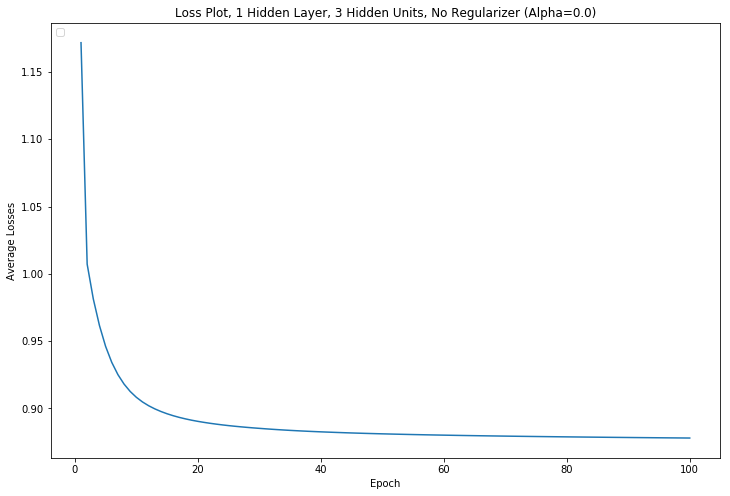

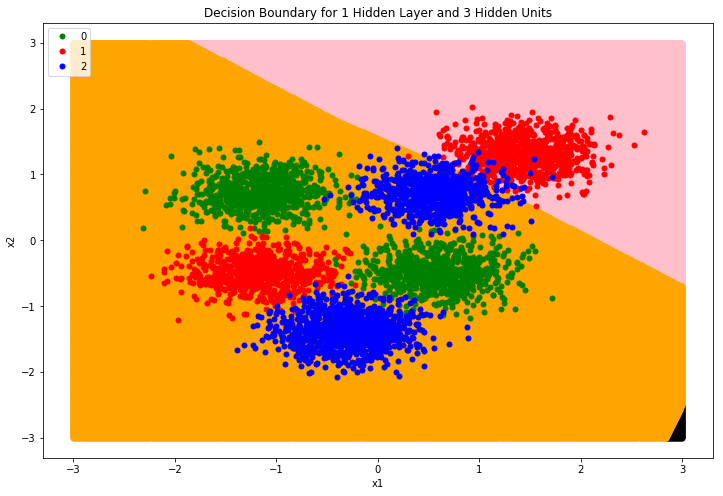

---------------------------------
---------------------------------
Scenario 2
---------------------------------
No regularizer is used
---------------------------------
Training for 1 hidden layer(s) and 8 hidden units
---------------------------------
Epoch: 10, Average Training Loss: 0.23194223152789267, Train Accuracy: 0.945
Epoch: 20, Average Training Loss: 0.15182353901235823, Train Accuracy: 0.9634
Epoch: 30, Average Training Loss: 0.12050680828139222, Train Accuracy: 0.968
Epoch: 40, Average Training Loss: 0.10159639927021179, Train Accuracy: 0.9708
Epoch: 50, Average Training Loss: 0.09088026711085091, Train Accuracy: 0.9724
Epoch: 60, Average Training Loss: 0.08477909240165628, Train Accuracy: 0.9726
Epoch: 70, Average Training Loss: 0.08136620701230224, Train Accuracy: 0.9724
Epoch: 80, Average Training Loss: 0.0789524756172793, Train Accuracy: 0.973
Epoch: 90, Average Training Loss: 0.0770499619775298, Train Accuracy: 0.9732


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Epoch: 100, Average Training Loss: 0.07522177812928232, Train Accuracy: 0.9744


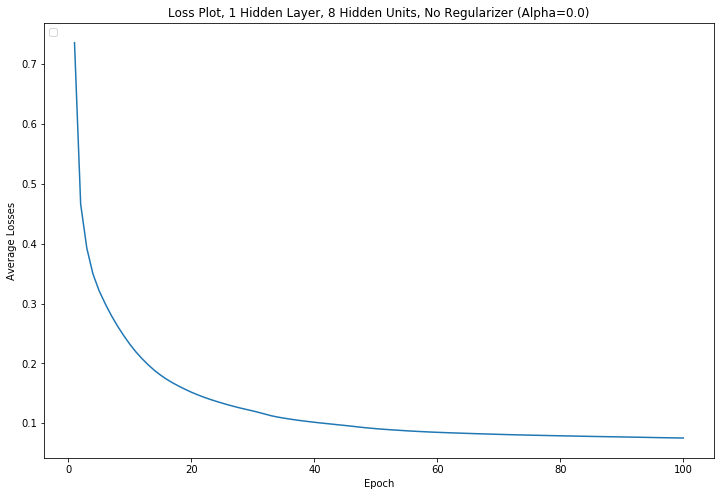

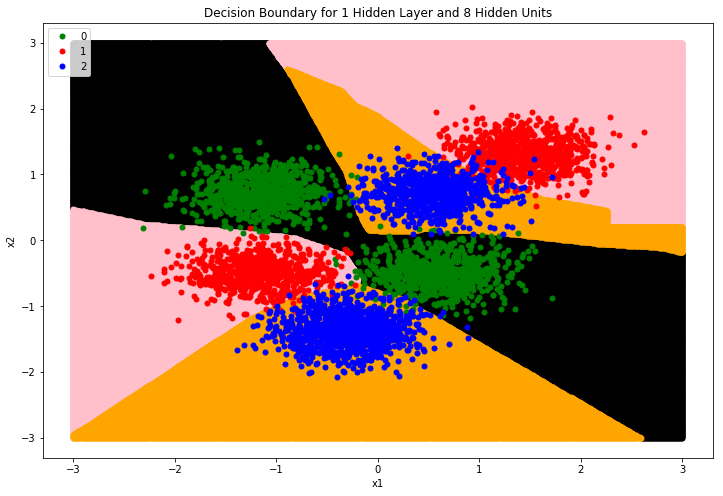

---------------------------------
---------------------------------
Scenario 3
---------------------------------
No regularizer is used
---------------------------------
Training for 1 hidden layer(s) and 16 hidden units
---------------------------------
Epoch: 10, Average Training Loss: 0.09651593810693218, Train Accuracy: 0.9692
Epoch: 20, Average Training Loss: 0.08055323196250867, Train Accuracy: 0.974
Epoch: 30, Average Training Loss: 0.07596880236456513, Train Accuracy: 0.976
Epoch: 40, Average Training Loss: 0.07373947010148314, Train Accuracy: 0.9762
Epoch: 50, Average Training Loss: 0.07234635298823967, Train Accuracy: 0.9768
Epoch: 60, Average Training Loss: 0.0714686096370156, Train Accuracy: 0.9772
Epoch: 70, Average Training Loss: 0.0707927349756349, Train Accuracy: 0.9772
Epoch: 80, Average Training Loss: 0.0703143952726726, Train Accuracy: 0.9774
Epoch: 90, Average Training Loss: 0.0699416850981945, Train Accuracy: 0.977


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Epoch: 100, Average Training Loss: 0.06963391812933688, Train Accuracy: 0.9768


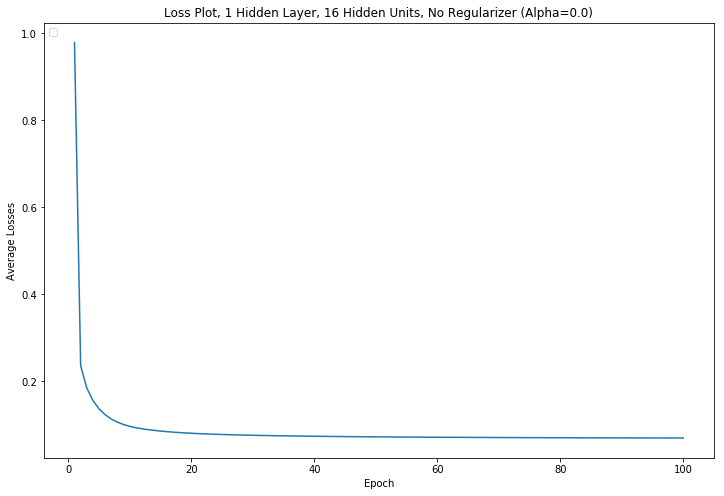

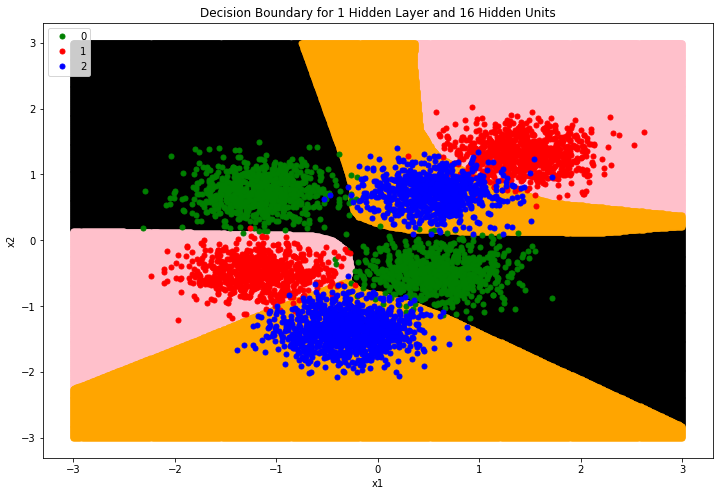

---------------------------------
---------------------------------
Scenario 4
---------------------------------
No regularizer is used
---------------------------------
Training for 3 hidden layer(s) and 3 hidden units
---------------------------------
Epoch: 10, Average Training Loss: 0.9124657829983034, Train Accuracy: 0.5098
Epoch: 20, Average Training Loss: 0.88495235365091, Train Accuracy: 0.524
Epoch: 30, Average Training Loss: 0.8796222411445409, Train Accuracy: 0.527
Epoch: 40, Average Training Loss: 0.877576932367006, Train Accuracy: 0.5284
Epoch: 50, Average Training Loss: 0.8764471482463343, Train Accuracy: 0.5294
Epoch: 60, Average Training Loss: 0.8756490393015348, Train Accuracy: 0.5292
Epoch: 70, Average Training Loss: 0.8750109787043768, Train Accuracy: 0.5292
Epoch: 80, Average Training Loss: 0.8744401342359724, Train Accuracy: 0.5288
Epoch: 90, Average Training Loss: 0.8738735887982981, Train Accuracy: 0.5282


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Epoch: 100, Average Training Loss: 0.873242193346748, Train Accuracy: 0.527


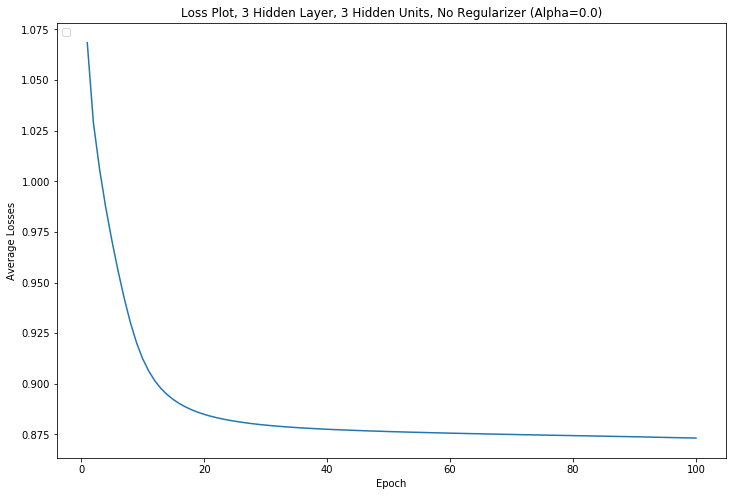

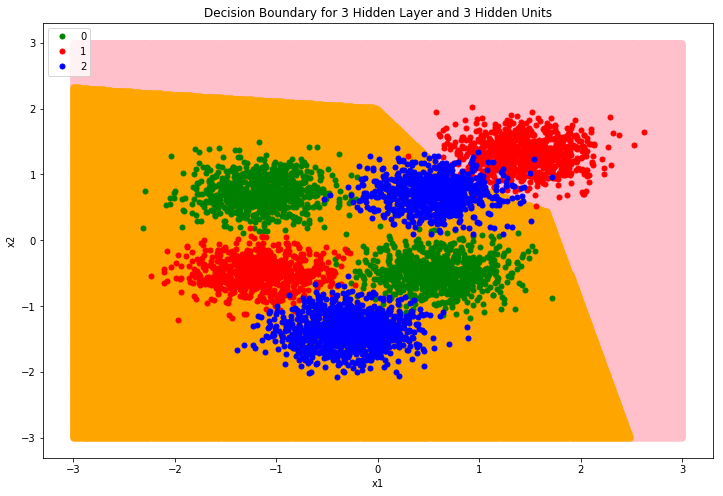

---------------------------------
---------------------------------
Scenario 5
---------------------------------
No regularizer is used
---------------------------------
Training for 3 hidden layer(s) and 8 hidden units
---------------------------------
Epoch: 10, Average Training Loss: 0.3883982901766426, Train Accuracy: 0.82
Epoch: 20, Average Training Loss: 0.30505749995683473, Train Accuracy: 0.831
Epoch: 30, Average Training Loss: 0.22843290884928766, Train Accuracy: 0.957
Epoch: 40, Average Training Loss: 0.17066614195714, Train Accuracy: 0.9702
Epoch: 50, Average Training Loss: 0.10230464292830235, Train Accuracy: 0.9726
Epoch: 60, Average Training Loss: 0.09037054923088368, Train Accuracy: 0.9742
Epoch: 70, Average Training Loss: 0.08669621476324256, Train Accuracy: 0.9742
Epoch: 80, Average Training Loss: 0.08353693569433379, Train Accuracy: 0.9742
Epoch: 90, Average Training Loss: 0.08126494888692987, Train Accuracy: 0.9748


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Epoch: 100, Average Training Loss: 0.07990286869287845, Train Accuracy: 0.9752


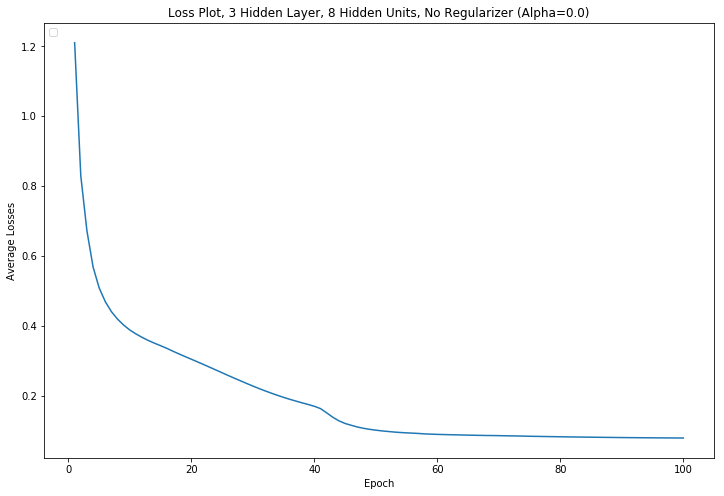

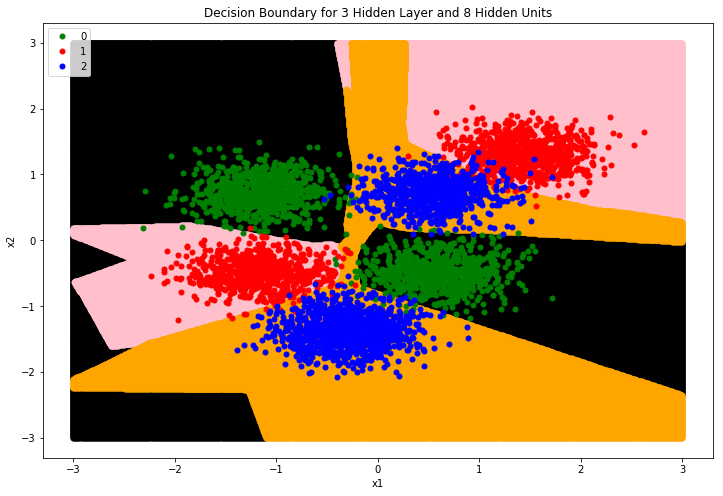

---------------------------------
---------------------------------
Scenario 6
---------------------------------
No regularizer is used
---------------------------------
Training for 3 hidden layer(s) and 16 hidden units
---------------------------------
Epoch: 10, Average Training Loss: 0.09110705722971595, Train Accuracy: 0.9742
Epoch: 20, Average Training Loss: 0.08419408688622095, Train Accuracy: 0.9738
Epoch: 30, Average Training Loss: 0.08151818886784974, Train Accuracy: 0.9746
Epoch: 40, Average Training Loss: 0.07948932592221256, Train Accuracy: 0.9754
Epoch: 50, Average Training Loss: 0.07672473917963679, Train Accuracy: 0.9766
Epoch: 60, Average Training Loss: 0.07566451911462263, Train Accuracy: 0.976
Epoch: 70, Average Training Loss: 0.07510137667536251, Train Accuracy: 0.976
Epoch: 80, Average Training Loss: 0.07370405528696908, Train Accuracy: 0.9758
Epoch: 90, Average Training Loss: 0.07371243193850324, Train Accuracy: 0.9766


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Epoch: 100, Average Training Loss: 0.07249714596507043, Train Accuracy: 0.9756


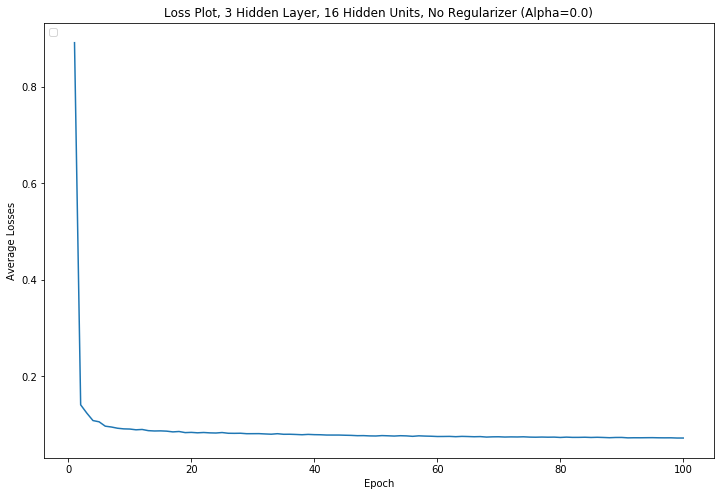

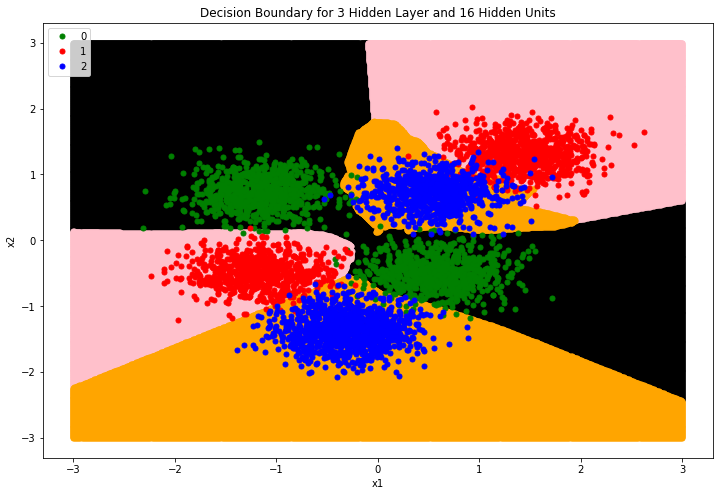

---------------------------------
---------------------------------
Scenario 7
---------------------------------
Regularizer is used
Regularization type: L2
Alpha: 0.1
---------------------------------
Training for 1 hidden layer(s) and 3 hidden units
---------------------------------
Epoch: 10, Average Training Loss: 0.8031092315999337, Train Accuracy: 0.6546
Epoch: 20, Average Training Loss: 0.6918072664807554, Train Accuracy: 0.7194
Epoch: 30, Average Training Loss: 0.6454065052419532, Train Accuracy: 0.7354
Epoch: 40, Average Training Loss: 0.6260701427416405, Train Accuracy: 0.7318
Epoch: 50, Average Training Loss: 0.6173975473612884, Train Accuracy: 0.7158
Epoch: 60, Average Training Loss: 0.6129409975626503, Train Accuracy: 0.705
Epoch: 70, Average Training Loss: 0.6103368168683805, Train Accuracy: 0.6894
Epoch: 80, Average Training Loss: 0.6088378945620633, Train Accuracy: 0.6808
Epoch: 90, Average Training Loss: 0.6085637138570412, Train Accuracy: 0.676


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Epoch: 100, Average Training Loss: 0.6086752976092797, Train Accuracy: 0.673


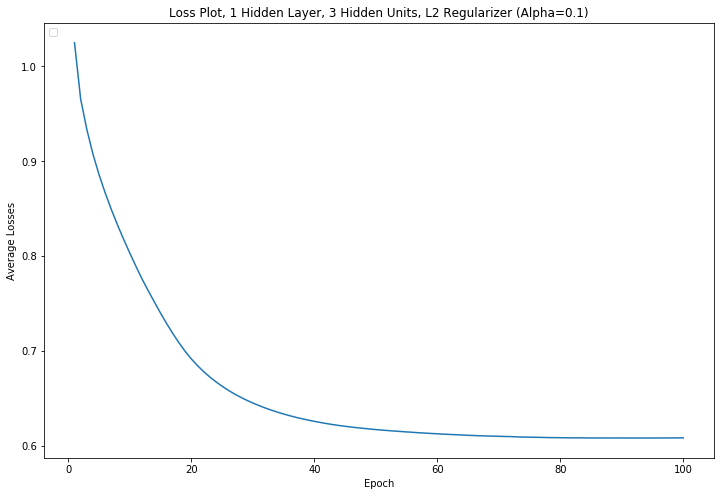

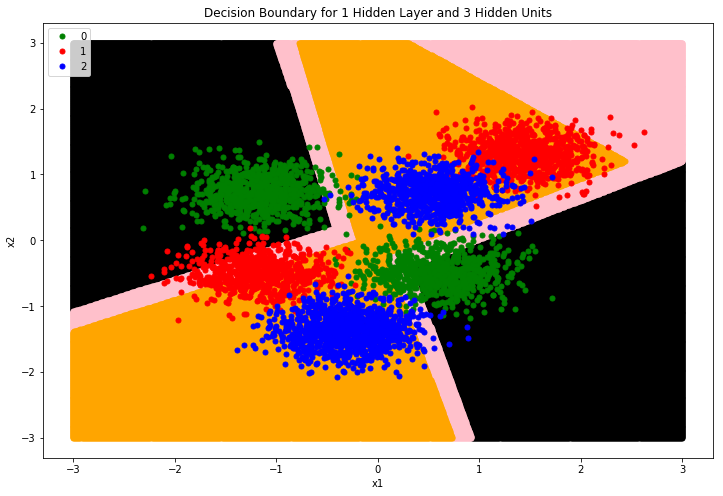

---------------------------------
---------------------------------
Scenario 8
---------------------------------
Regularizer is used
Regularization type: L2
Alpha: 0.1
---------------------------------
Training for 1 hidden layer(s) and 8 hidden units
---------------------------------
Epoch: 10, Average Training Loss: 0.35718321235593464, Train Accuracy: 0.9298
Epoch: 20, Average Training Loss: 0.28952456803030635, Train Accuracy: 0.9594
Epoch: 30, Average Training Loss: 0.25970488578499695, Train Accuracy: 0.9648
Epoch: 40, Average Training Loss: 0.24742748359012995, Train Accuracy: 0.9664
Epoch: 50, Average Training Loss: 0.24062636460161563, Train Accuracy: 0.9686
Epoch: 60, Average Training Loss: 0.2360654202663033, Train Accuracy: 0.971
Epoch: 70, Average Training Loss: 0.2328473354611869, Train Accuracy: 0.9722
Epoch: 80, Average Training Loss: 0.23136875073909668, Train Accuracy: 0.973
Epoch: 90, Average Training Loss: 0.23094901914433152, Train Accuracy: 0.974


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Epoch: 100, Average Training Loss: 0.23094378714463215, Train Accuracy: 0.9736


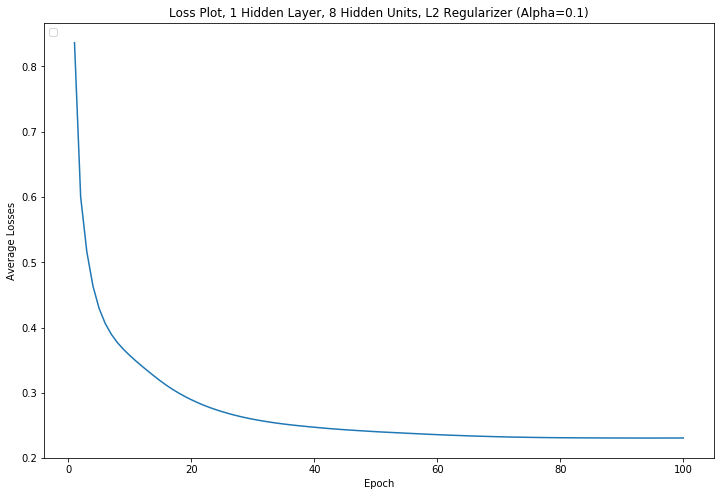

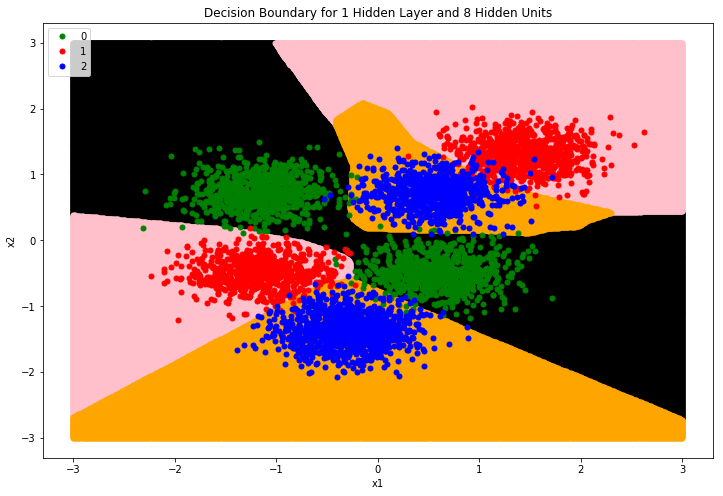

---------------------------------
---------------------------------
Scenario 9
---------------------------------
Regularizer is used
Regularization type: L2
Alpha: 0.1
---------------------------------
Training for 1 hidden layer(s) and 16 hidden units
---------------------------------
Epoch: 10, Average Training Loss: 0.5004498815453481, Train Accuracy: 0.9714
Epoch: 20, Average Training Loss: 0.48897569241064837, Train Accuracy: 0.9744
Epoch: 30, Average Training Loss: 0.48588014721006967, Train Accuracy: 0.9752
Epoch: 40, Average Training Loss: 0.48500024892949734, Train Accuracy: 0.9748
Epoch: 50, Average Training Loss: 0.48503697391555545, Train Accuracy: 0.9752
Epoch: 60, Average Training Loss: 0.4853145589450148, Train Accuracy: 0.9754
Epoch: 70, Average Training Loss: 0.48568460690287746, Train Accuracy: 0.976
Epoch: 80, Average Training Loss: 0.4860610016008089, Train Accuracy: 0.9756
Epoch: 90, Average Training Loss: 0.4863987876065133, Train Accuracy: 0.9756


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Epoch: 100, Average Training Loss: 0.48673924225712517, Train Accuracy: 0.9758


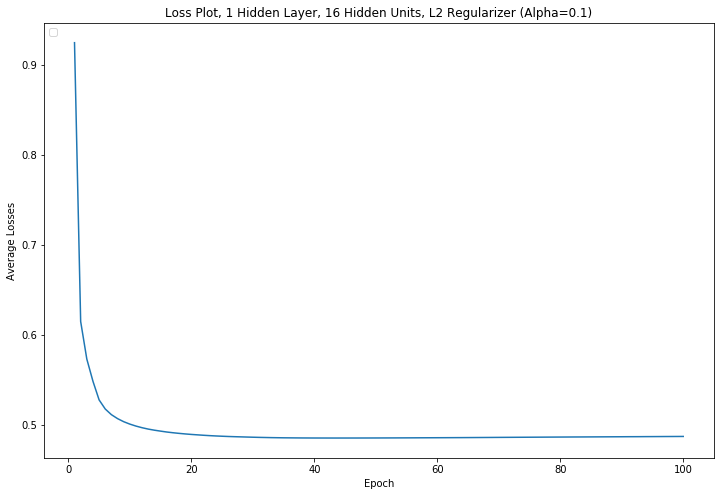

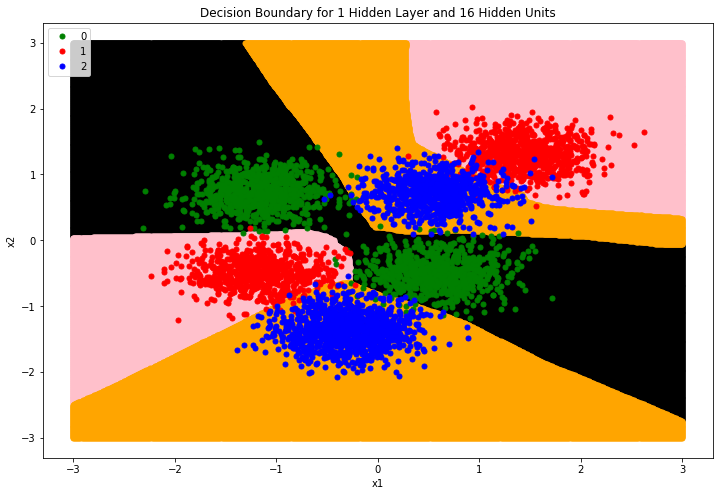

---------------------------------
---------------------------------
Scenario 10
---------------------------------
Regularizer is used
Regularization type: L2
Alpha: 0.1
---------------------------------
Training for 3 hidden layer(s) and 3 hidden units
---------------------------------
Epoch: 10, Average Training Loss: 0.5715925627216432, Train Accuracy: 0.7844
Epoch: 20, Average Training Loss: 0.4895032568064439, Train Accuracy: 0.8058
Epoch: 30, Average Training Loss: 0.4433244959017764, Train Accuracy: 0.8202
Epoch: 40, Average Training Loss: 0.240087388116434, Train Accuracy: 0.9664
Epoch: 50, Average Training Loss: 0.16712158317131667, Train Accuracy: 0.967
Epoch: 60, Average Training Loss: 0.15298786139523018, Train Accuracy: 0.968
Epoch: 70, Average Training Loss: 0.14902413323118302, Train Accuracy: 0.9686
Epoch: 80, Average Training Loss: 0.1476978080086625, Train Accuracy: 0.9686
Epoch: 90, Average Training Loss: 0.14734198588171007, Train Accuracy: 0.969


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Epoch: 100, Average Training Loss: 0.1471884066219681, Train Accuracy: 0.9698


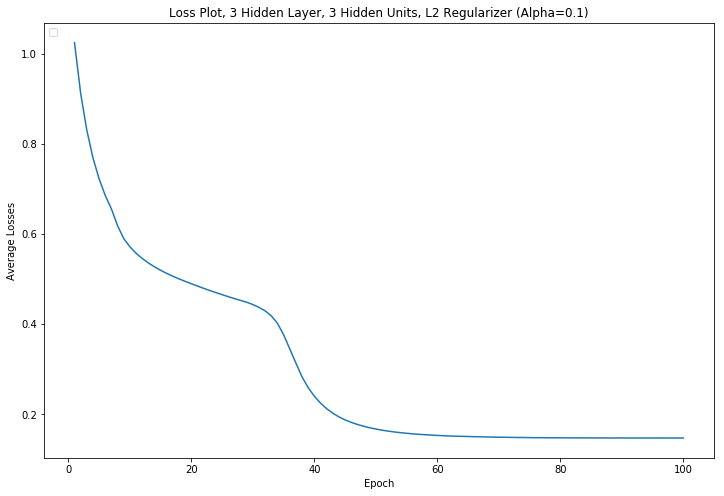

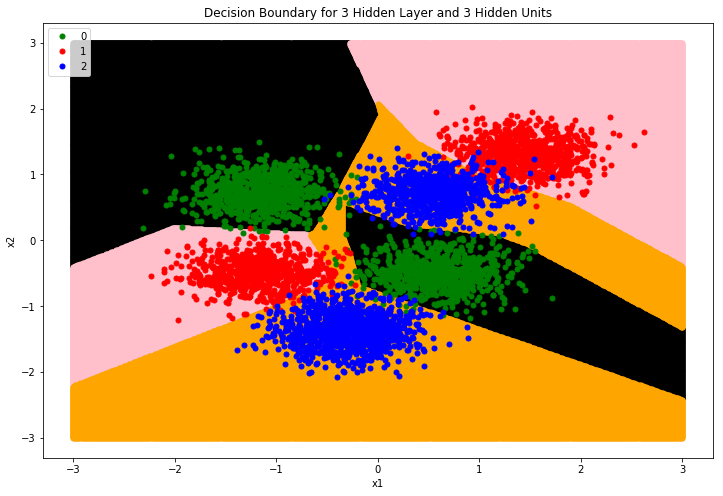

---------------------------------
---------------------------------
Scenario 11
---------------------------------
Regularizer is used
Regularization type: L2
Alpha: 0.1
---------------------------------
Training for 3 hidden layer(s) and 8 hidden units
---------------------------------
Epoch: 10, Average Training Loss: 0.4436616598106859, Train Accuracy: 0.9062
Epoch: 20, Average Training Loss: 0.2802514040203498, Train Accuracy: 0.9654
Epoch: 30, Average Training Loss: 0.25634806544881866, Train Accuracy: 0.9626
Epoch: 40, Average Training Loss: 0.2504735979375828, Train Accuracy: 0.9684
Epoch: 50, Average Training Loss: 0.24809447663962184, Train Accuracy: 0.9668
Epoch: 60, Average Training Loss: 0.24521041574359648, Train Accuracy: 0.9686
Epoch: 70, Average Training Loss: 0.243945589603592, Train Accuracy: 0.9694
Epoch: 80, Average Training Loss: 0.2433582008429097, Train Accuracy: 0.9698
Epoch: 90, Average Training Loss: 0.24278746854282496, Train Accuracy: 0.9704


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Epoch: 100, Average Training Loss: 0.24203711747626225, Train Accuracy: 0.9704


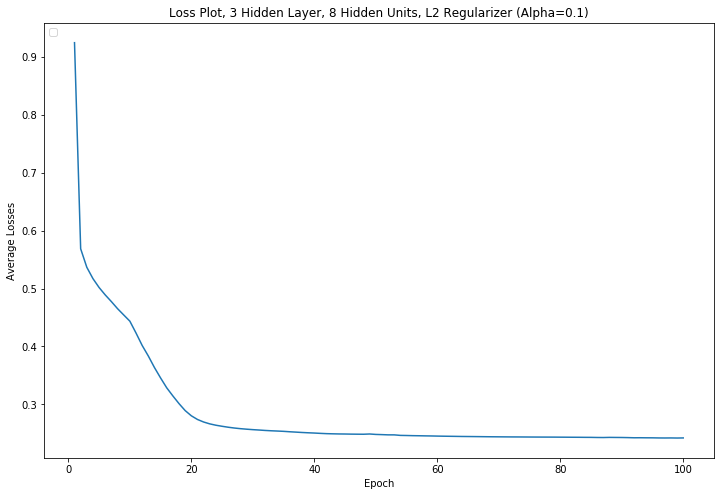

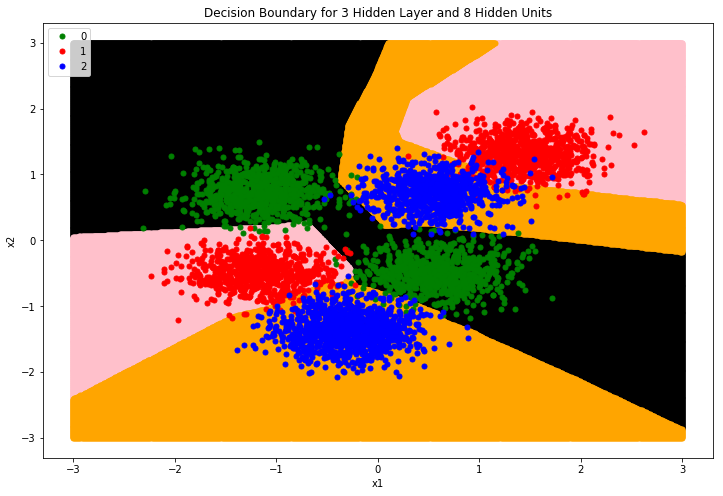

---------------------------------
---------------------------------
Scenario 12
---------------------------------
Regularizer is used
Regularization type: L2
Alpha: 0.1
---------------------------------
Training for 3 hidden layer(s) and 16 hidden units
---------------------------------
Epoch: 10, Average Training Loss: 0.6223983982201744, Train Accuracy: 0.9722
Epoch: 20, Average Training Loss: 0.6135729270526931, Train Accuracy: 0.9746
Epoch: 30, Average Training Loss: 0.6106513228396155, Train Accuracy: 0.9744
Epoch: 40, Average Training Loss: 0.6084264975403298, Train Accuracy: 0.975
Epoch: 50, Average Training Loss: 0.6064070084663331, Train Accuracy: 0.9754
Epoch: 60, Average Training Loss: 0.6045722922855352, Train Accuracy: 0.9752
Epoch: 70, Average Training Loss: 0.6031309508355226, Train Accuracy: 0.974
Epoch: 80, Average Training Loss: 0.6027984197138141, Train Accuracy: 0.9754
Epoch: 90, Average Training Loss: 0.6023437358849691, Train Accuracy: 0.9748


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Epoch: 100, Average Training Loss: 0.6015268616423435, Train Accuracy: 0.9766


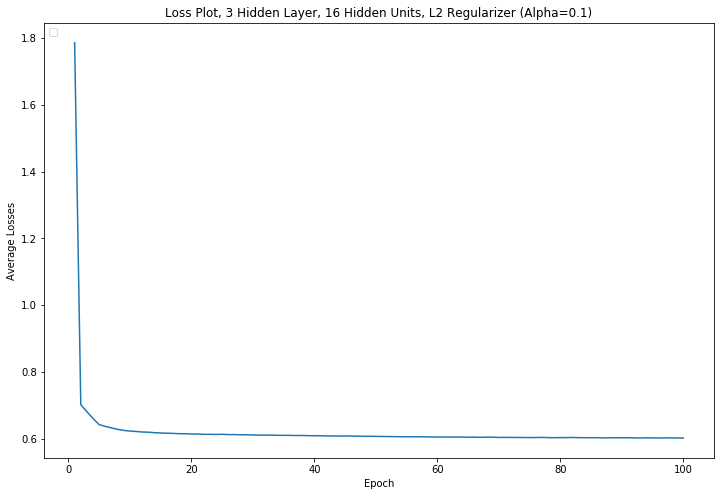

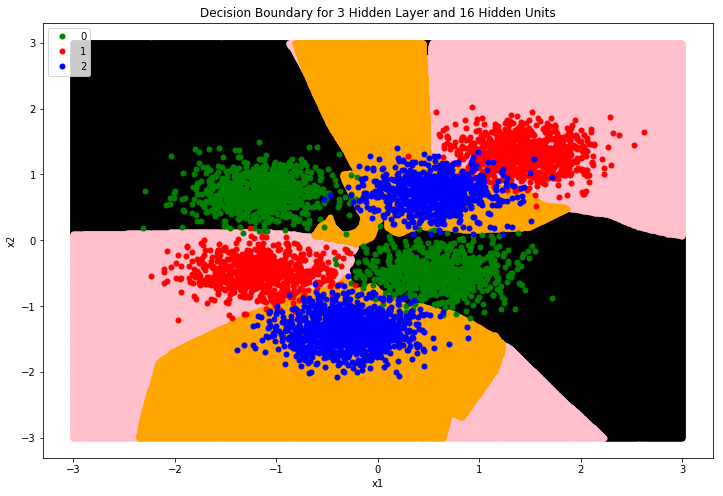

---------------------------------
---------------------------------
Scenario 13
---------------------------------
Regularizer is used
Regularization type: L2
Alpha: 1.0
---------------------------------
Training for 1 hidden layer(s) and 3 hidden units
---------------------------------
Epoch: 10, Average Training Loss: 0.9100893689044387, Train Accuracy: 0.7594
Epoch: 20, Average Training Loss: 0.8676577884402487, Train Accuracy: 0.8056
Epoch: 30, Average Training Loss: 0.8623513464089517, Train Accuracy: 0.8146
Epoch: 40, Average Training Loss: 0.867815825723818, Train Accuracy: 0.8616
Epoch: 50, Average Training Loss: 0.885877530105559, Train Accuracy: 0.8804
Epoch: 60, Average Training Loss: 0.9077972403678137, Train Accuracy: 0.886
Epoch: 70, Average Training Loss: 0.9216638137206663, Train Accuracy: 0.9022
Epoch: 80, Average Training Loss: 0.924260341543447, Train Accuracy: 0.9184
Epoch: 90, Average Training Loss: 0.9286910575568657, Train Accuracy: 0.9262


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Epoch: 100, Average Training Loss: 0.9350246847304777, Train Accuracy: 0.93


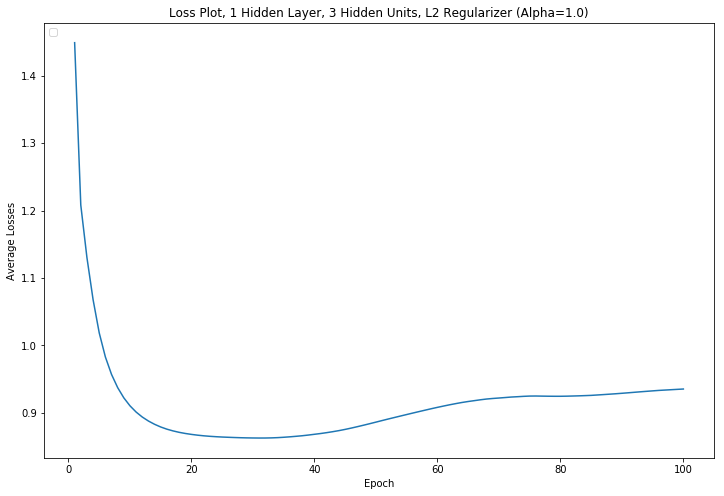

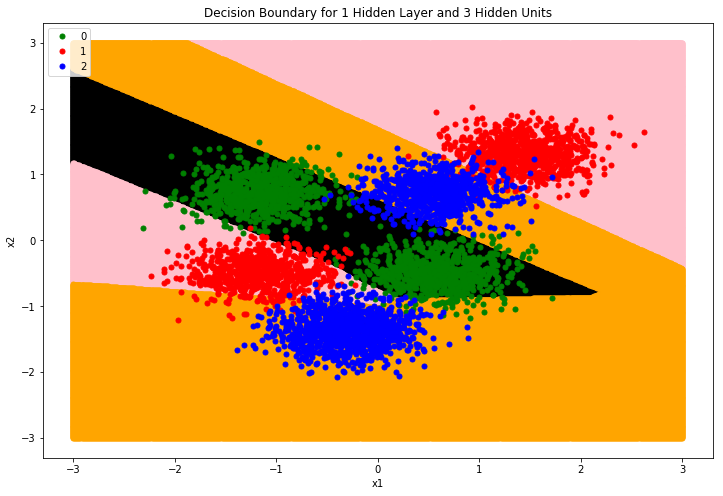

---------------------------------
---------------------------------
Scenario 14
---------------------------------
Regularizer is used
Regularization type: L2
Alpha: 1.0
---------------------------------
Training for 1 hidden layer(s) and 8 hidden units
---------------------------------
Epoch: 10, Average Training Loss: 1.2369733945161887, Train Accuracy: 0.9668
Epoch: 20, Average Training Loss: 1.2707349482555161, Train Accuracy: 0.972
Epoch: 30, Average Training Loss: 1.3101371457298046, Train Accuracy: 0.9726
Epoch: 40, Average Training Loss: 1.3391605176206565, Train Accuracy: 0.9732
Epoch: 50, Average Training Loss: 1.361706535192252, Train Accuracy: 0.9738
Epoch: 60, Average Training Loss: 1.3801874291230263, Train Accuracy: 0.9734
Epoch: 70, Average Training Loss: 1.3954569365066662, Train Accuracy: 0.9732
Epoch: 80, Average Training Loss: 1.4083662591831865, Train Accuracy: 0.9736
Epoch: 90, Average Training Loss: 1.4197384957746582, Train Accuracy: 0.9742


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Epoch: 100, Average Training Loss: 1.4298324054198759, Train Accuracy: 0.9744


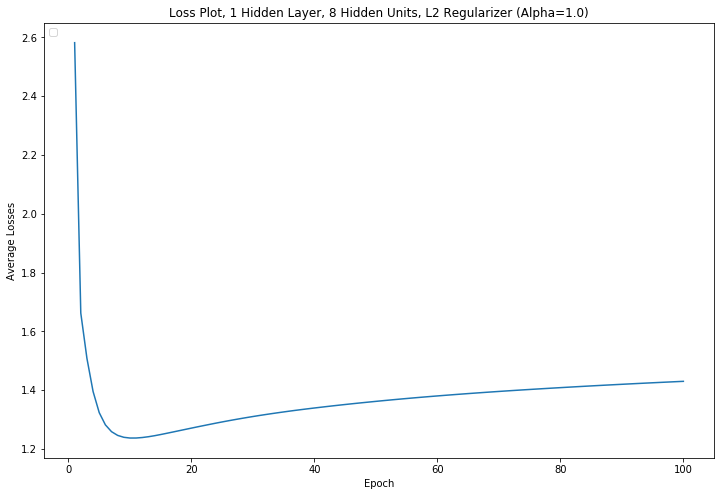

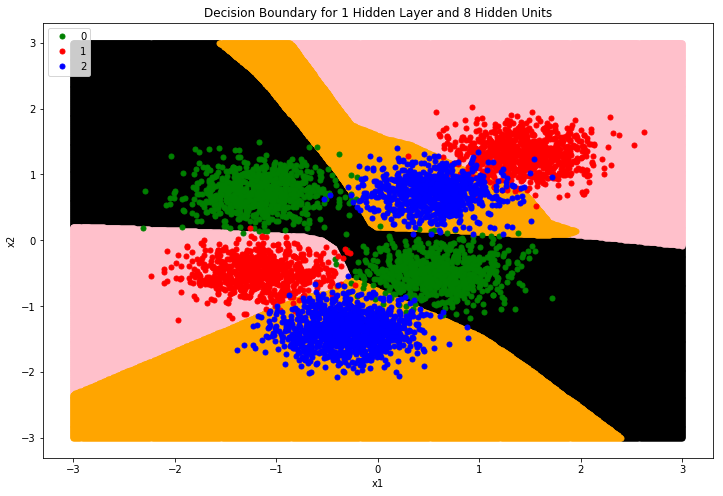

---------------------------------
---------------------------------
Scenario 15
---------------------------------
Regularizer is used
Regularization type: L2
Alpha: 1.0
---------------------------------
Training for 1 hidden layer(s) and 16 hidden units
---------------------------------
Epoch: 10, Average Training Loss: 3.9589435124698547, Train Accuracy: 0.9636
Epoch: 20, Average Training Loss: 3.9768439252503662, Train Accuracy: 0.9718
Epoch: 30, Average Training Loss: 3.9997714791961347, Train Accuracy: 0.9734
Epoch: 40, Average Training Loss: 4.01856739684743, Train Accuracy: 0.9742
Epoch: 50, Average Training Loss: 4.034136742159595, Train Accuracy: 0.9746
Epoch: 60, Average Training Loss: 4.046932007924607, Train Accuracy: 0.9756
Epoch: 70, Average Training Loss: 4.057687949387496, Train Accuracy: 0.9762
Epoch: 80, Average Training Loss: 4.066883670787635, Train Accuracy: 0.9758
Epoch: 90, Average Training Loss: 4.074899349301921, Train Accuracy: 0.9762


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Epoch: 100, Average Training Loss: 4.082065041188618, Train Accuracy: 0.9762


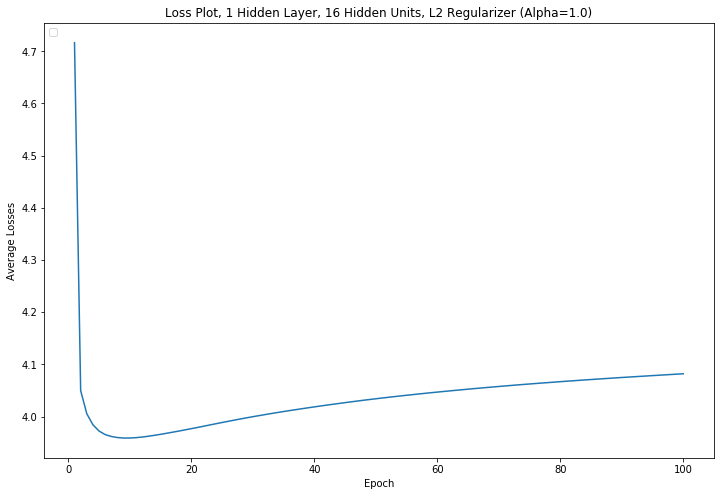

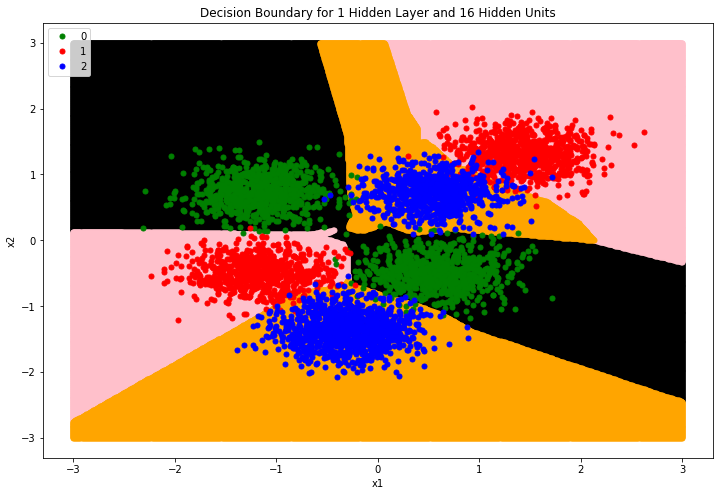

---------------------------------
---------------------------------
Scenario 16
---------------------------------
Regularizer is used
Regularization type: L2
Alpha: 1.0
---------------------------------
Training for 3 hidden layer(s) and 3 hidden units
---------------------------------
Epoch: 10, Average Training Loss: 0.8131005631875605, Train Accuracy: 0.774
Epoch: 20, Average Training Loss: 0.7979630104015211, Train Accuracy: 0.796
Epoch: 30, Average Training Loss: 0.7684758887630873, Train Accuracy: 0.7892
Epoch: 40, Average Training Loss: 0.7574162884395977, Train Accuracy: 0.7806
Epoch: 50, Average Training Loss: 0.7368566308933627, Train Accuracy: 0.7996
Epoch: 60, Average Training Loss: 0.7420322576138798, Train Accuracy: 0.8034
Epoch: 70, Average Training Loss: 0.751309136652748, Train Accuracy: 0.8032
Epoch: 80, Average Training Loss: 0.757730839373112, Train Accuracy: 0.8024
Epoch: 90, Average Training Loss: 0.7625904416685085, Train Accuracy: 0.8004


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Epoch: 100, Average Training Loss: 0.7664403752700634, Train Accuracy: 0.7972


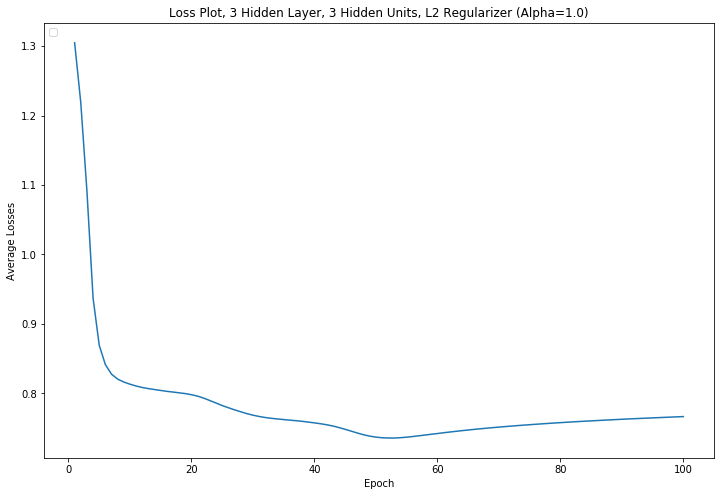

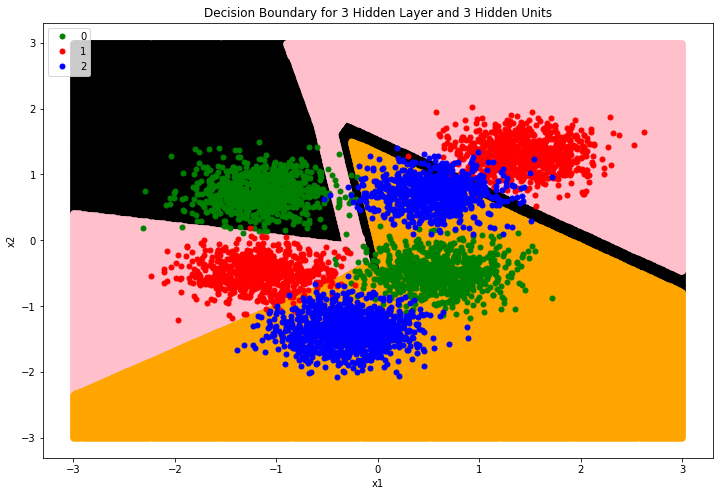

---------------------------------
---------------------------------
Scenario 17
---------------------------------
Regularizer is used
Regularization type: L2
Alpha: 1.0
---------------------------------
Training for 3 hidden layer(s) and 8 hidden units
---------------------------------
Epoch: 10, Average Training Loss: 1.5819091843554227, Train Accuracy: 0.9578
Epoch: 20, Average Training Loss: 1.5688462570871033, Train Accuracy: 0.9682
Epoch: 30, Average Training Loss: 1.5658203639737707, Train Accuracy: 0.9696
Epoch: 40, Average Training Loss: 1.5649835617615313, Train Accuracy: 0.9698
Epoch: 50, Average Training Loss: 1.5638194964615488, Train Accuracy: 0.97
Epoch: 60, Average Training Loss: 1.5627639722606852, Train Accuracy: 0.9724
Epoch: 70, Average Training Loss: 1.5629453035462009, Train Accuracy: 0.9746
Epoch: 80, Average Training Loss: 1.5631102263665415, Train Accuracy: 0.9748
Epoch: 90, Average Training Loss: 1.563321499355889, Train Accuracy: 0.975


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Epoch: 100, Average Training Loss: 1.5636570045947547, Train Accuracy: 0.9752


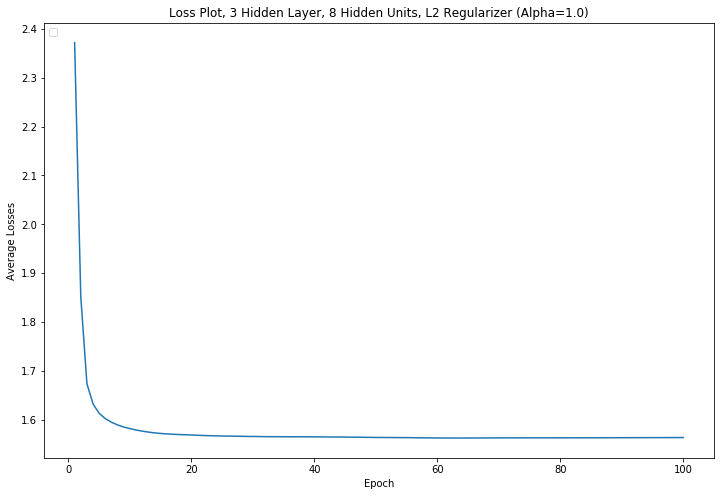

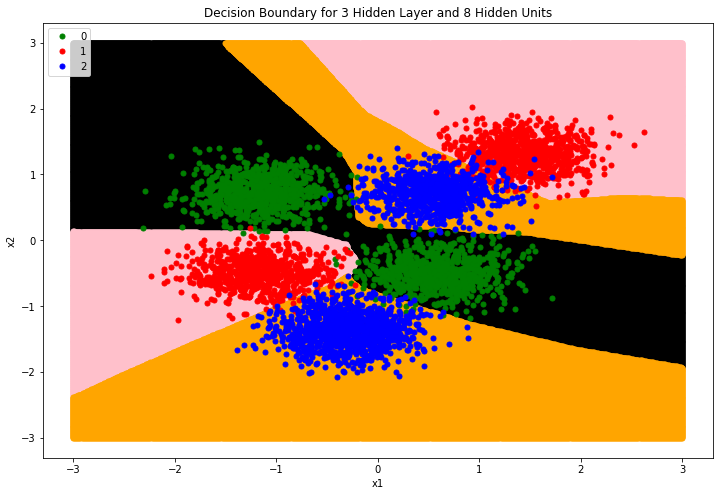

---------------------------------
---------------------------------
Scenario 18
---------------------------------
Regularizer is used
Regularization type: L2
Alpha: 1.0
---------------------------------
Training for 3 hidden layer(s) and 16 hidden units
---------------------------------
Epoch: 10, Average Training Loss: 5.282042966899943, Train Accuracy: 0.9696
Epoch: 20, Average Training Loss: 5.269458034243307, Train Accuracy: 0.9714
Epoch: 30, Average Training Loss: 5.261856118608658, Train Accuracy: 0.9732
Epoch: 40, Average Training Loss: 5.255264531379309, Train Accuracy: 0.9738
Epoch: 50, Average Training Loss: 5.24855214525798, Train Accuracy: 0.9752
Epoch: 60, Average Training Loss: 5.243050939075945, Train Accuracy: 0.976
Epoch: 70, Average Training Loss: 5.237897038375802, Train Accuracy: 0.976
Epoch: 80, Average Training Loss: 5.233439725641707, Train Accuracy: 0.9764
Epoch: 90, Average Training Loss: 5.230712462371547, Train Accuracy: 0.977


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Epoch: 100, Average Training Loss: 5.228604975040596, Train Accuracy: 0.977


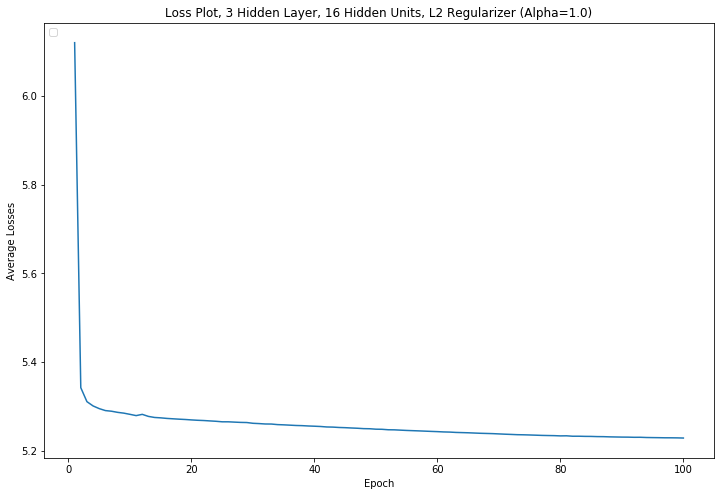

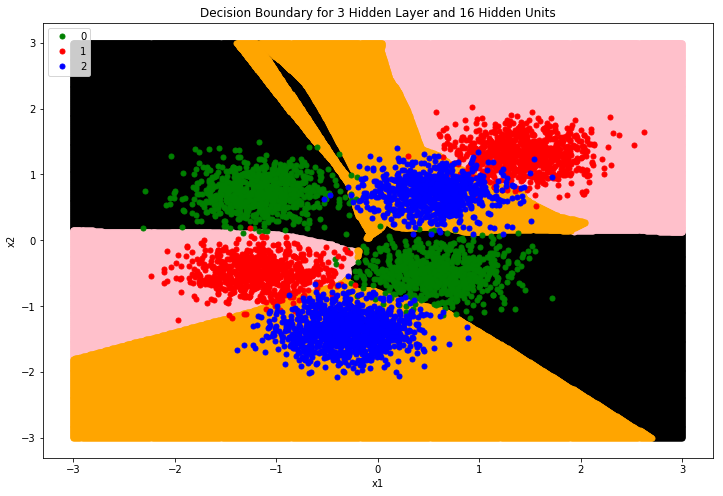

---------------------------------
---------------------------------


In [23]:
scenario = {
    'n_hidden_layers': [1, 3],
    'n_hidden_units': [3, 8, 16],
    'regularizers': [ 
        None, {
            'reg_type': 'L2',
            'alpha': 0.1
        }, {
            'reg_type': 'L2',
            'alpha': 1.0
        } 
    ]
}

do_train(scenario)

### d) Re-use this same network on any data of your own choosing. You can increase the dimensionality of the features space as you like. You can also change the number of classes to just two or more than three to align with your data. Separate your data into three piles: training, testing, and validation. Use your testing data to decide when to stop training if appropriate. Use your validation set to compute the accuracy of you classfier.

#### Data Description

I use image data, taken from `Google`. The classes are `Central Park` and `Time Square`. Each class has `120` data in total, with `96` of them being the train set and the other `24` of them being the test set. This is the same data that I used for `HW1` and `HW2`.

In [24]:
!pip install matplotlib numpy opencv-python scipy 

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.6/bin/python3 -m pip install --upgrade pip' command.


In [25]:
!ls "data/train/centralpark" | wc -l
!ls "data/train/timesquare" | wc -l
!ls "data/test/centralpark" | wc -l
!ls "data/test/timesquare" | wc -l

      96
      96
      24
      24


#### Imports and Dir Constants

In [26]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import cv2

from scipy.stats import multivariate_normal
from datetime import datetime

base_path        = 'data'
train_path       = base_path + '/train'
test_path        = base_path + '/test'

#### Determine Fixed Size

I find that for both train and test data, there is no image with lower resolution than 200x200, so I pick that as my fixed size

In [27]:
def fetch_dim(image, label):
    height, width, channels = image.shape
    return label, height, width

def find_min_size(is_train, threshold):
    # Pick the corresponding path
    if is_train:
        print('Find in train data ...')
        data_path = train_path
    else:
        print('Find in test data ...')
        data_path = test_path

    # Get the labels, sorted, in this case it's just ['cats', 'dogs']
    classes = sorted(os.listdir(data_path))

    # Array to store image size
    image_sizes = []

    # Loop over each dir, each corresponds to a label
    for label in classes:
        # Get dir full path
        dir = os.path.join(data_path, label)
      
        if '.DS_Store' not in dir:
            # Loop over the images in the dir
            for image_file in os.listdir(dir):
                image_path = os.path.join(dir, image_file)

                # Calculate size
                if 'HEIC' not in image_path:
                    image = cv2.imread(image_path)
                    image_sizes.append(fetch_dim(image, label))

    # Return all image sizes that are less than the size threshold
    return [elem for elem in image_sizes if elem[0] == classes[0] and elem[1] < threshold and elem[2] < threshold], [elem for elem in image_sizes if elem[0] == classes[1] and elem[1] < threshold and elem[2] < threshold]

train_min_size = find_min_size(True, 200)
print(len(train_min_size[0]), len(train_min_size[1]))

test_min_size = find_min_size(False, 200)
print(len(test_min_size[0]), len(test_min_size[1]))

# Set fixed_size constant
fixed_size = tuple([200, 200])

Find in train data ...
0 0
Find in test data ...
0 0


#### Feature Extractor Function

I use Color Histogram from OpenCV as my feature, with the following detail:
1. Using three channels (RGB), denoted by [0 1 2]
2. The color range is default, 0 to 256
3. There are 8 bins (I handpick this, no particular reason).

The above scenario results in a feature vector of size 512.

In [28]:
bins = 8

# Color Histogram Feature
# a. Convert the image to HSV color-space
# b. Compute the color histogram
# c. Normalize the histogram
def compute_histogram(image, mask=None):
    hist = cv2.calcHist([cv2.cvtColor(image, cv2.COLOR_BGR2HSV)], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

#### Precompute the Features for Train and Test Data

In [29]:
image_sizes = []

def precompute_features(is_train, is_timed):
    if is_timed:
        start = datetime.now()

    # Pick the corresponding path
    if is_train:
        print('Precomputing train data features...')
        data_path = train_path
    else:
        print('Precomputing test data features...')
        data_path = test_path

    # Placeholder for returned features and labels
    features = []
    labels = []

    # Get the labels, sorted, in this case it's ['centralpark', 'timesquare']
    classes = sorted(os.listdir(data_path))
    
    # Loop over each dir, each corresponds to a label
    for label in classes:
        # Get dir full path
        dir = os.path.join(data_path, label)

        if '.DS_Store' not in dir:
            # Loop over the images in the dir
            for image_file in os.listdir(dir):
                image_path = os.path.join(dir, image_file)

                # Resize image, refer to the previous constant
                if 'HEIC' not in image_path:
                    image = cv2.imread(image_path)
                    image_sizes.append(fetch_dim(image, label))
                    image = cv2.resize(image, fixed_size)

                # Extract three different features
                hist = compute_histogram(image) 
                # print(hist.shape) #(512, )

                # Append to placeholder
                features.append(hist)
                labels.append(label)

            print("Time elapsed: {}".format(datetime.now() - start)) 
            print("Processed dir: {}".format(label))
    
    return np.array(features), labels

train_features, train_labels = precompute_features(True, True)
print('--------------------')
test_features, test_labels = precompute_features(False, True)

assert train_features.shape == (192, 512)
assert test_features.shape == (48, 512)

assert len(train_labels) == 192
assert len(test_labels) == 48
print('--------------------')

Precomputing train data features...
Time elapsed: 0:00:01.051295
Processed dir: centralpark
Time elapsed: 0:00:02.987145
Processed dir: timesquare
--------------------
Precomputing test data features...
Time elapsed: 0:00:00.175962
Processed dir: centralpark
Time elapsed: 0:00:00.436030
Processed dir: timesquare
--------------------


Convert `X` and `y` into `np.array`

In [30]:
# Convert string label to numeric, 'centralpark' as 0 and 'timesquare' as 1
y_train_image = np.array([0.0 if label == 'centralpark' else 1.0 for label in train_labels])
y_test_image = np.array([0.0 if label == 'centralpark' else 1.0 for label in test_labels])

X_train = np.array(train_features)
y_train = np.array(y_train_image)[:, np.newaxis]

X_test = np.array(test_features)
y_test = np.array(y_test_image)[:, np.newaxis]

print(X_train.shape)

print(X_test.shape)

print(y_train.shape)
print(y_train[0])
print(y_train[128])

print(y_test.shape)
print(y_test[0])
print(y_test[25])


(192, 512)
(48, 512)
(192, 1)
[0.]
[1.]
(48, 1)
[0.]
[1.]


Apply `one hot encoding` to `y`, do sanity check by comparing the `y` printed above

In [31]:
data_train = np.array(y_train_image.flatten(), dtype='int32')
shape_train = (data_train.size, int(data_train.max() + 1))

y_train = np.zeros(shape_train)
rows_train = np.arange(data_train.size)

y_train[rows_train, data_train] = 1.0

data_test = np.array(y_test_image.flatten(), dtype='int32')
shape_test = (data_test.size, int(data_test.max() + 1))

y_test = np.zeros(shape_test)
rows_test = np.arange(data_test.size)

y_test[rows_test, data_test] = 1.0

print(y_train.shape)
print(y_train[0])
print(y_train[128])

print(y_test.shape)
print(y_test[0])
print(y_test[25])

(192, 2)
[1. 0.]
[0. 1.]
(48, 2)
[1. 0.]
[0. 1.]


Train using $3$ hidden layers and $128$ hidden units. Use `Softmax Cross Entropy` loss. Set `learning rate` to $0.01$ and `number of epochs` to $100$. Set `minibatch size` to $256$.

In [32]:
# Use 3 Hidden Layers, 128 Units each
n_hidden_layers, n_hidden_units = (3, 128)

# Use L2 REGULARIZER with ALPHA=1.0
regularizer = {
    'reg_type': 'L2',
    'alpha': 0.1
}

NN = MLP(debug=False)

# Input Layer of shape (512, 128) with 512 being the size of feature
NN.add_layer('Input', dim_in=512, dim_out=n_hidden_units)
# Use ReLU activation for Input Layer
NN.add_layer('Activation_Relu')

# Use 2 Hidden Layers
for _ in range(0, n_hidden_layers):
    # Hidden Layer of shape (128, 128) with 128 being the number of hidden units
    NN.add_layer('Hidden', dim_in=n_hidden_units, dim_out=n_hidden_units)
    # Also use ReLU activation for Hidden Layer
    NN.add_layer('Activation_Relu')

# Output Layer of shape (128, 2) with 2 in dim_out being the number of classes
NN.add_layer('Output', dim_in=n_hidden_units, dim_out=2)
# Use Softmax activation to get smooth class probabilities
NN.add_layer('Activation_Softmax')

# Cross Entropy Loss Layer to compute the loss based on Softmax activations
NN.add_layer('Loss_Cross_Entropy')

# Finally, train the NN and fetch the losses
print('Regularizer is used')
print('Regularization type: {}'.format(regularizer['reg_type']))
print('Alpha: {}'.format(regularizer['alpha']))
print('---------------------------------')

print('Training for {} hidden layer(s) and {} hidden units'.format(n_hidden_layers, n_hidden_units))
print('---------------------------------')

# LEARNING_RATE = 0.01 (also Keras default) and BSIZE=8 since the number of data is very small (~200)
# Thus, for every epoch, there will be ~25 minibatches
# EPOCHS is set to 100, pretty standard
losses = NN.train(X_train, y_train, learning_rate=0.01, epochs=100, bsize=8, regularizer=regularizer)

Regularizer is used
Regularization type: L2
Alpha: 0.1
---------------------------------
Training for 3 hidden layer(s) and 128 hidden units
---------------------------------


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in log
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in multiply
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater


Epoch: 10, Average Training Loss: nan, Train Accuracy: 0.5
Epoch: 20, Average Training Loss: nan, Train Accuracy: 0.5
Epoch: 30, Average Training Loss: nan, Train Accuracy: 0.5
Epoch: 40, Average Training Loss: nan, Train Accuracy: 0.5
Epoch: 50, Average Training Loss: nan, Train Accuracy: 0.5
Epoch: 60, Average Training Loss: nan, Train Accuracy: 0.5
Epoch: 70, Average Training Loss: nan, Train Accuracy: 0.5
Epoch: 80, Average Training Loss: nan, Train Accuracy: 0.5
Epoch: 90, Average Training Loss: nan, Train Accuracy: 0.5
Epoch: 100, Average Training Loss: nan, Train Accuracy: 0.5


No handles with labels found to put in legend.
No handles with labels found to put in legend.


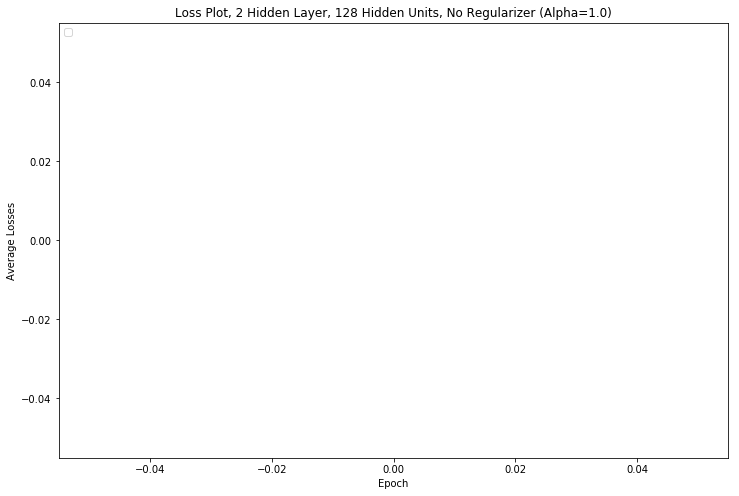

In [33]:
plot_losses(losses, 'Loss Plot, {} Hidden Layer, {} Hidden Units, No Regularizer (Alpha={})'.format(2, 128, 0.1))

Finally, compute the `test accuracy`

In [34]:
NN.compute_accuracy(X_test, y_test)

0.5